# ComCam: The impact of using a different number of donut pairs and binning settings on the wavefront retrieval

In this document we investigate the effect of choosing a different number of donut pairs per LsstComCam detector for wavefront sensing using Danish or TIE algorithms. We also test the impact of binning the image data. 
 

Last verified to run: 03/10/2025

Versions:

* **lsst_distrib** w_2025_08 (ext, cvmfs)

* **ts_wep** v13.4.1

## Imports 

In [43]:
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.time import Time
import astropy.units as u
from copy import copy
from lsst.daf.butler import Butler
from lsst.ts.wep.utils import makeDense, makeSparse, convertZernikesToPsfWidth, binArray
import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm
import os

## Input

We use the existing donut stamps in `/repo/main`, collection `u/brycek/aosBaseline_step1a`. This run `ISR` and `ts_wep` donut detection and cutouts on the ComCam data where `exposure.observation_type = 'cwfs'`. The pipetask used `step1a` of  [comCamBaselineUSDF_Danish.yaml](https://github.com/lsst-ts/ts_wep/blob/develop/pipelines/production/comCamBaselineUSDF_Danish.yaml) , which imports [comCamBaselineUSDF_Danish.yaml](https://github.com/lsst-ts/ts_wep/blob/develop/pipelines/_ingredients/wepDirectDetectScienceGroupPipeline.yaml) . The combined pipeline config  for `step1a` included: 

    instrument: lsst.obs.lsst.LsstComCam
      isr:
        class: lsst.ip.isr.IsrTaskLSST
        config:
          # Although we don't have to apply the amp offset corrections, we do want
          # to compute them for analyzeAmpOffsetMetadata to report on as metrics.
          doAmpOffset: True
          ampOffset.doApplyAmpOffset: False
          # Turn off slow steps in ISR
          doBrighterFatter: False
          # Mask saturated pixels,
          # but turn off quadratic crosstalk because it's currently broken
          doSaturation: True
          crosstalk.doQuadraticCrosstalkCorrection: False
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
          donutSelector.sourceLimit: -1
      cutOutDonutsScienceSensorGroupTask:
        class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
        config:
          python: |
            from lsst.ts.wep.task.pairTask import GroupPairer
            config.pairer.retarget(GroupPairer)
          donutStampSize: 200
          initialCutoutPadding: 40

This resulted in  `22452` unique dataset references with `donutStampsExtra`, `donutStampsIntra` (i.e. combinations of exposure - detector data elements that cab be accessed by butler). 



## Data Processing

The above was processed using [batch processing service (bps)](https://developer.lsst.io/usdf/batch.html) at the US Data Facility (USDF). Following the `ssh` to `s3df` and one of the submission nodes (eg. `sdfiana012`), we [setup the LSST Science Pipelines and the AOS packages](https://rubinobs.atlassian.net/wiki/spaces/LTS/pages/50082164/Onboarding+to+LSST+AOS). Ensuring the presence of `site_bps.yaml` in the submission directory containing 

    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200
        
we obtain glidee in nodes with 

    allocateNodes.py -v -n 15 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning

The basis of employed pipetask configs are [comCamBaselineUSDF_Danish.yaml](https://github.com/lsst-ts/ts_wep/blob/develop/pipelines/production/comCamBaselineUSDF_Danish.yaml) and [comCamBaselineUSDF_TIE.yaml](https://github.com/lsst-ts/ts_wep/blob/develop/pipelines/production/comCamBaselineUSDF_TIE.yaml). 

These were used to create  `lsstComCamPipelineDanish.yaml` containing:


    description: rerun lsstComCam Danish baseline with different binning
    instrument: lsst.obs.lsst.LsstComCam
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesDanishTask)
          donutStampSelector.maxFracBadPixels: 2.0e-4
          estimateZernikes.binning: 1
          estimateZernikes.nollIndices:
            [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 27, 28]
          estimateZernikes.saveHistory: False
          estimateZernikes.lstsqKwargs:
            ftol: 1.0e-3
            xtol: 1.0e-3
            gtol: 1.0e-3
          donutStampSelector.maxSelect: -1
      aggregateZernikeTablesTask:
        class: lsst.donut.viz.AggregateZernikeTablesTask
      aggregateDonutTablesGroupTask:
          class: lsst.donut.viz.AggregateDonutTablesTask
          config:
              python: |
                  from lsst.ts.wep.task.pairTask import GroupPairer
                  config.pairer.retarget(GroupPairer)
      aggregateAOSVisitTableTask:
        class: lsst.donut.viz.AggregateAOSVisitTableTask
    
      plotAOSTask:
        class: lsst.donut.viz.PlotAOSTask
        config:
          doRubinTVUpload: false
    
      aggregateDonutStampsTask:
        class: lsst.donut.viz.AggregateDonutStampsTask
    
      plotDonutTask:
       class: lsst.donut.viz.PlotDonutTask
       config:
         doRubinTVUpload: false

and `lsstComCamPipelineTie.yaml` containing:


    description: rerun lsstComCam TIE baseline with different binning
    instrument: lsst.obs.lsst.LsstComCam
    tasks:  
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          estimateZernikes.binning: 1
          estimateZernikes.nollIndices: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 27, 28]
          estimateZernikes.convergeTol: 10.0e-9
          estimateZernikes.compGain: 0.75
          estimateZernikes.compSequence: [4, 4, 6, 6, 13, 13, 13, 13]
          estimateZernikes.maxIter: 50
          estimateZernikes.requireConverge: True
          estimateZernikes.saveHistory: False
          estimateZernikes.maskKwargs: { "doMaskBlends": False }
          donutStampSelector.maxFracBadPixels: 2.0e-4
          donutStampSelector.maxSelect: -1
    
      aggregateZernikeTablesTask:
        class: lsst.donut.viz.AggregateZernikeTablesTask
      aggregateDonutTablesGroupTask:
          class: lsst.donut.viz.AggregateDonutTablesTask
          config:
              python: |
                  from lsst.ts.wep.task.pairTask import GroupPairer
                  config.pairer.retarget(GroupPairer)
      aggregateAOSVisitTableTask:
        class: lsst.donut.viz.AggregateAOSVisitTableTask
    
      plotAOSTask:
        class: lsst.donut.viz.PlotAOSTask
        config:
          doRubinTVUpload: false
    
      aggregateDonutStampsTask:
        class: lsst.donut.viz.AggregateDonutStampsTask
    
      plotDonutTask:
       class: lsst.donut.viz.PlotDonutTask
       config:
         doRubinTVUpload: false

Main modification to the original `ts_wep` pipeline was to set `estimateZernikes.nollIndices` to be identical for Danish and TIE versions. 

Image binning takes place at the image level, and is possible for both [Danish](https://github.com/lsst-ts/ts_wep/blob/6ee8d950dd8b5381e5ba9218d4f8294aeb372016/python/lsst/ts/wep/estimation/danish.py#L206-L208) and [TIE algorithms](https://github.com/lsst-ts/ts_wep/blob/d4ed86efe430d3ae02a10a971c29dd5cc8ad0fa1/python/lsst/ts/wep/estimation/tie.py#L702-L723).  We change the image binning by seting `estimateZernikes.binning` to `1` to `2` or `4`, creating `_binning_1`, etc versions of each pipeline.  

We submit all with bps for `Danish`:


    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_danish_binning_1 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineDanish_binning_1.yaml 

    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_danish_binning_2 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineDanish_binning_2.yaml 

    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_danish_binning_2 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineDanish_binning_4.yaml 

and `TIE`: 


    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_tie_binning_1 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineTie_binning_1.yaml 

    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_tie_binning_2 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineTie_binning_2.yaml

    bps submit site_bps.yaml -b /repo/main -i u/brycek/aosBaseline_step1a,LSSTComCam/calib/unbounded -o u/scichris/aosBaseline_tie_binning_4 -p /sdf/data/rubin/shared/scichris/DM-48441_N_donuts_LsstComCam/lsstComCamPipelineTie_binning_4.yaml

## Binning and image resolution

Configuring `estimateZernikes.binning` to a value larger than 1 means that both intra- and extra-focal images are reduced in resolution before being analyzed by the chosen algorithm (Danish or TIE). An example **simulated** image of ComCam binned by a factor of x1 (no binning), x2, x4, is shown below:  

In [19]:
butlerRootPath = "/sdf/data/rubin/repo/aos_imsim/"
butler = Butler(butlerRootPath)
registry = butler.registry
refs = butler.query_datasets(
    "donutStampsExtra",
    collections=["WET-001_lsstComCam_TIE_6001_6200_bps"],
    where="instrument='LSSTComCam' and detector = 4",
)
donutStampsExtra = butler.get(
    "donutStampsExtra",
    dataId=refs[60].dataId,
    collections=["WET-001_lsstComCam_TIE_6001_6200_bps"],
)


Text(0.5, 0.1, 'x [px]')

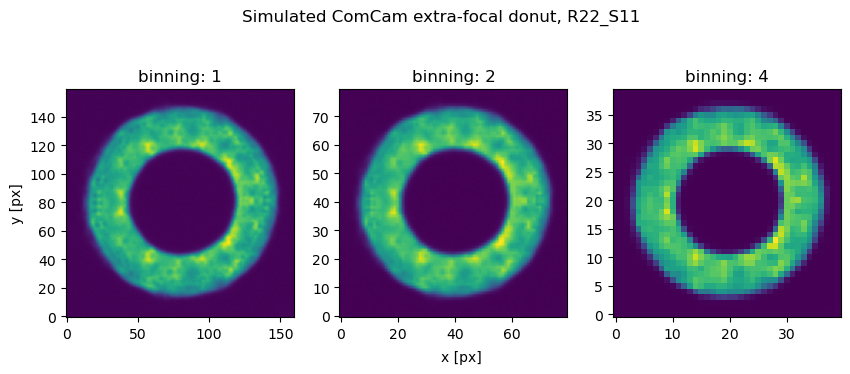

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
image = donutStampsExtra[0].stamp_im.image.array

for i, binning in enumerate([1, 2, 4]):
    binned_image = binArray(image, binning)
    ax[i].imshow(binned_image, origin="lower")
    ax[i].set_title(f"binning: {binning}")
ax[0].set_ylabel("y [px]")
fig.suptitle("Simulated ComCam extra-focal donut, R22_S11")
fig.text(
    0.5,
    0.1,
    "x [px]",
)


The reduction of resolution degrades the content of information, and potentially decreases the task execution time, as shown below.

## Impact on runtime

To compare runtime of different `estimateZernikes.binning` settings, we read the information stored in `task_metadata`, and `task_log` dataset types. Due to the number of involved visits, we ran the attached scripts `read_runtime` and `clean_runtime` via slurm individually per method / binning.


In [64]:
results_timing = {}
for method in ['tie', 'danish']:
    results_timing[method] = {}
    for binning in [1, 2, 4]:
        
        fname = f"DM-49211_u_scichris_aosBaseline_binning_{binning}_{method}_timing_table.txt"
        if os.path.exists(fname):
            results_timing[method][binning] = Table.read(fname, format='ascii')
        else:
            print(f"Need to first execute python read_runtime and clean_runtime in the technote github repository")

The execution time is obtained from `calcZernikesTask_metadata`, between `quantum/prepUtc` and `quantum/endUtc`

Text(0.5, 1.0, 'Calculate Zernikes: \nruntime per detector')

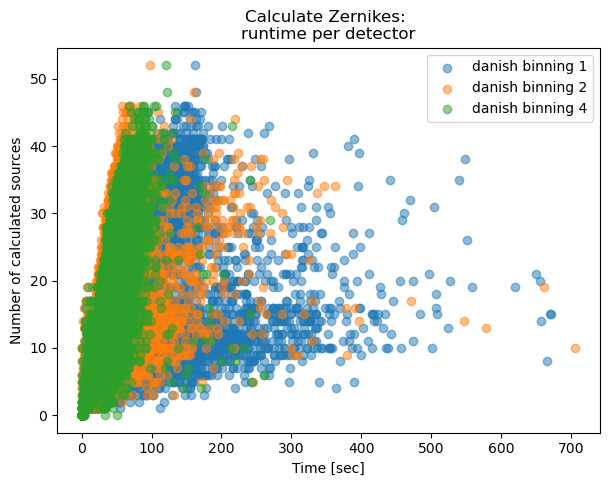

In [10]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
method = 'danish'
for binning in  [1,2,4]:
    results =  results_timing[method]
    ax.scatter(results_timing[method][binning]['cwfsTime'], results_timing[method][binning]['NobjCalc'], label=f'{method} binning {binning}',
              alpha=0.5)
ax.legend()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Number of calculated sources')
ax.set_title('Calculate Zernikes: \nruntime per detector')

Text(0.5, 1.0, 'Calculate Zernikes: \nruntime per detector')

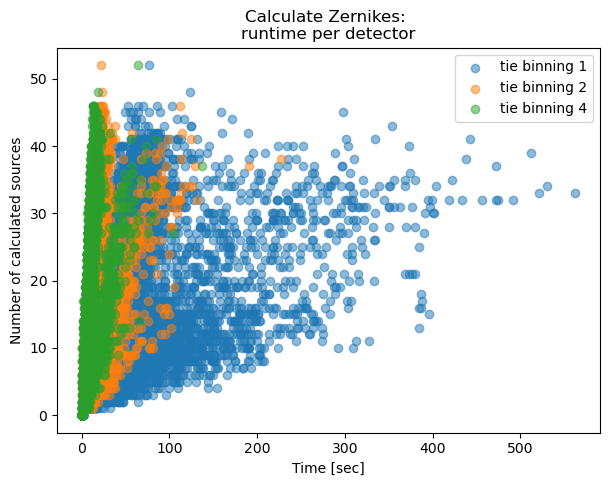

In [14]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
method = 'tie'
for binning in  [1,2,4]:
    results =  results_timing[method]
    ax.scatter(results_timing[method][binning]['cwfsTime'], results_timing[method][binning]['NobjCalc'], label=f'{method} binning {binning}',
              alpha=0.5)
ax.legend()
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Number of calculated sources')
ax.set_title('Calculate Zernikes: \nruntime per detector')

We can divide the execution time per number of sources, and plot a histogram  per method / binning:

tie, binning x1, median execution time: 2.096354374999887
tie, binning x2, median execution time: 0.6352792857156889
tie, binning x4, median execution time: 0.44021016666695445
danish, binning x1, median execution time: 3.813606406593311
danish, binning x2, median execution time: 1.8558818888883977
danish, binning x4, median execution time: 2.37407587857106


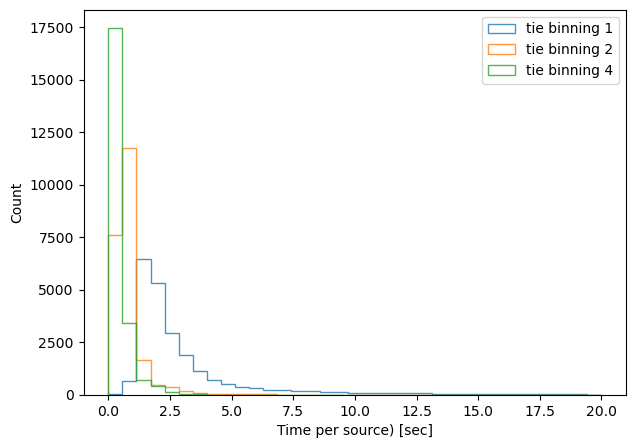

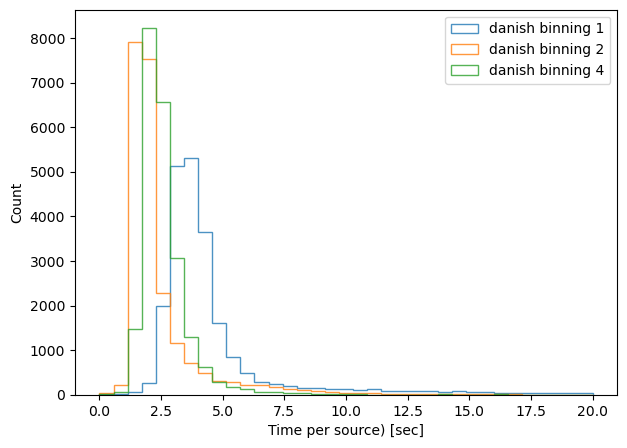

In [21]:
for method in results_timing.keys():
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    for binning in  [1,2,4]:
        ls = 'dashed' if method == 'tie' else 'solid'
        cwfs_time = np.array(results_timing[method][binning]['cwfsTime'])
        nobj_calc = np.array(results_timing[method][binning]['NobjCalc'])
        m = nobj_calc>0
        time_per_obj = cwfs_time[m] / nobj_calc[m]
        ax.hist(time_per_obj, histtype='step', lw=3, ls=ls, label=f'{method} binning {binning}', alpha=0.8,
               bins=35, range=(0,20)
               )
             
        print(f'{method}, binning x{binning}, median execution time: {np.median(time_per_obj)}')
    ax.set_xlabel('Time per source) [sec]')
    ax.set_ylabel('Count')
    ax.legend()
    

As expected, binning reduces the task execution time. Both methods are shown in the same scale, highlighting the fact that the TIE algoritm is slightly faster than Danish (with x2 binning, median `0.63` sec/source  for TIE vs `1.85` sec/source for Danish). Next we consider an extent to which this image quality degradation affects the inferred wavefront, selecting only datasets with multiple donut stamps selected per detector.

## Sample Selection

The initial dataset includes all data labelled as defocal:

In [2]:
butler = Butler("/repo/main")
input_collection =  "u/brycek/aosBaseline_step1a" # only data labelled with observation_type as cwfs
refs = butler.query_datasets('donutStampsExtra',  collections=[input_collection], limit=None)
len(refs)

22452

It corresponds to `2500` unique visits: 

In [4]:
visits, count =  np.unique(list(ref.dataId["visit"] for ref in refs), return_counts=True)
print(len(np.unique(visits)))

2500


However, only `2474` have data for all 9 detectors at the same time:

In [5]:
good_visits = visits[np.where(count == 9)]
print(len(np.unique(good_visits)))

2474


Each bps run above produced `donutQualityTable` with data for both intra and extra-focal exposure in the same group, such as:


In [6]:
wep_collection = 'u/scichris/aosBaseline_danish_binning_1'
refs = butler.query_datasets('zernikes',  collections=[wep_collection], limit=1)
donutQualityTable = butler.get('donutQualityTable', dataId=refs[0].dataId, collections=[wep_collection]) 

In [7]:
donutQualityTable[:5]

<QTable length=5>
       SN            ENTROPY      FRAC_BAD_PIX ... FINAL_SELECT DEFOCAL_TYPE
    float64          float64        float64    ...     bool         str5    
---------------- ---------------- ------------ ... ------------ ------------
5137.41357421875 1.31518296329074          0.0 ...         True        extra
1318.29467773438 3.24980303079286          0.0 ...         True        extra
978.061645507812  3.5127111308061          0.0 ...        False        extra
924.204772949219 3.52984575330561          0.0 ...        False        extra
791.558532714844 3.75901379543286          0.0 ...        False        extra

Each `donutQualityTable` is created by the [donutStampSelector](https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/donutStampSelectorTask.py), called by `calcZernikesTask` during wavefront estimation. It combines individual donut stamp information calculated by `cutOutDonutsBase` during the cutout stage, and applies selection criteria (such as `maxFracBadPixels` or `maxEntropy`) to set `FINAL_SELECT` flag that [passes only select donut stamp pairs](https://github.com/lsst-ts/ts_wep/blob/6ee8d950dd8b5381e5ba9218d4f8294aeb372016/python/lsst/ts/wep/task/calcZernikesTask.py#L404-L409) to `estimateZernikes` task. Using the `FINAL_SELECT` column, we count the number of donuts per detector that were admitted in the Zernike estimation:

In [ ]:
# Get information about how many donuts made it through selection criteria 
# by reading all `donutQualityTables` :
butler = Butler('/repo/main')
wep_collection = 'u/scichris/aosBaseline_danish_binning_1'

# First , want to make sure that all detectors got processed per visit.
refs = butler.query_datasets('zernikes',  collections=[wep_collection], limit=None)
visits, count =  np.unique(list(ref.dataId["visit"] for ref in refs), return_counts=True)
good_visits = visits[np.where(count == 9)]
print(f'{len(good_visits)} / {len(visits)} have data for all detectors')

nDonutsQualityTable = []
nDonutsQualityTableIntra = []
nDonutsQualityTableExtra = []
visits = []
dets = []

for ref in tqdm(refs, desc="Processing"):
    if ref.dataId["visit"] in good_visits:
        # Note: there's one `donutQualityTable` for intra and extra-focal pair. 
        donutQualityTable = butler.get('donutQualityTable', dataId=ref.dataId, collections=[wep_collection]) 
        nDonutsQualityTable.append(np.sum(donutQualityTable['FINAL_SELECT']))
        donutQualityTableExtra = donutQualityTable[donutQualityTable['DEFOCAL_TYPE'] == 'extra']
        donutQualityTableIntra = donutQualityTable[donutQualityTable['DEFOCAL_TYPE'] == 'intra']
        nDonutsQualityTableIntra.append(np.sum(donutQualityTableIntra['FINAL_SELECT']))
        nDonutsQualityTableExtra.append(np.sum(donutQualityTableExtra['FINAL_SELECT']))
        visits.append(ref.dataId['visit'])
        dets.append(ref.dataId['detector'])
        
#Store the full table:
donutQualityTableNdonuts = Table(data=[nDonutsQualityTable, nDonutsQualityTableIntra,
                                       nDonutsQualityTableExtra,
                                       visits,dets], 
                                 names=['Ndonuts', 'NdonutsIntra', 'NdonutsExtra', 
                                                            'visit', 'detector'])
fnameDonutTable = 'u_scichris_aosBaseline_danish1_donutQualityTable_N_donuts.txt'
donutQualityTableNdonuts.write(fnameDonutTable, format='ascii')

Of `2474` visits, `2457` have processed `Zernike` data for all 9 detectors. We select a subset that has at least 9 donuts in each detector:

In [ ]:
fnameDonutTable = 'u_scichris_aosBaseline_danish1_donutQualityTable_N_donuts.txt'
donutQualityTableNdonuts = Table.read(fnameDonutTable, format='ascii')

m = (donutQualityTableNdonuts['NdonutsIntra'] > 8 ) * ( donutQualityTableNdonuts['NdonutsExtra'] > 8 ) 
donutTableSubset = donutQualityTableNdonuts[m]

good_visits  = []
for visit in np.unique(donutTableSubset['visit']):
    rows  = donutTableSubset[donutTableSubset['visit'] == visit]
    if len(rows) == 9: # all detectors fulfill the number of donuts criterion
        good_visits.append(visit)
mask = np.isin(donutTableSubset['visit'] , good_visits)
donutQualityTableSel = donutTableSubset[mask]
fnameDonutTableSel = 'u_scichris_aosBaseline_danish1_donutQualityTable_N_donuts_select.txt'
donutQualityTableSel.write(fnameDonutTableSel, format='ascii')

In [81]:
print(f'The table includes {len(donutQualityTableSel)} dataRefs, with {len(good_visits)} unique visits')

The table includes 5166 dataRefs, with 574 unique visits


## Data analysis

We reorganize all `zernikes` tables  for selected visits using the `read_zernikes_comcam` script, and subsequently add donut magnitude converting `source_flux` that is stored in each `donutQualityTable`:

In [22]:
path_cwd = os.getcwd()
fname = os.path.join(path_cwd, f'u_scichris_aosBaseline_tie_danish_zernikes_tables_604.npy')
results_visit = np.load(fname, allow_pickle=True).item()

fnameSelectionTable = 'u_scichris_aosBaseline_danish1_donutQualityTable_N_donuts_select.txt'
donutQualityTableSel = Table.read(fnameSelectionTable, format='ascii')

visits_calculated = np.unique(list(results_visit.keys()))
visits_selected  = np.unique(donutQualityTableSel['visit'])
visits_available = visits_selected[np.isin(visits_selected, visits_calculated)]

In [ ]:
# Setup butler 
butler =  Butler('/repo/main')

results_visit_mags = {}
for visit  in tqdm(visits_available, desc="Processing"):
    
    results_mags = {}
    for detector in range(9):

        dataId = {'instrument':'LSSTComCam', 'detector':detector, 
                'visit':visit
             }
        donutTableExtra = butler.get('donutTable', dataId=dataId, collections=['u/brycek/aosBaseline_step1a'])
        donutQualityTable = butler.get('donutQualityTable', dataId=dataId, collections=['u/scichris/aosBaseline_tie_binning_1'])

        extraDonuts = donutQualityTable[donutQualityTable['DEFOCAL_TYPE'] == 'extra']
        extraDonuts['index'] = np.arange(len(extraDonuts))

        extraIndices = extraDonuts[extraDonuts['FINAL_SELECT']]['index']
        idxExtra = np.array(extraIndices.data, dtype=int)

        donutTableExtraSelect = donutTableExtra[idxExtra]
        mags  = (donutTableExtra[idxExtra]['source_flux'].value * u.nJy).to_value(u.ABmag)
        
        results_mags[detector] = { 'donutStampsExtraMag':mags}
    results_visit_mags[visit] = results_mags

Nvisits = len(visits_available)
file = f'u_scichris_aosBaseline_tie_danish_mag_visit_{Nvisits}.npy'
np.save(file, results_visit_mags, allow_pickle=True)

## Increasing the number of donuts

We plot the average of N donuts pairs, as we start from N=1 (single donut pair), to N=9 (average of nine donut pairs). Each panel corresponds to an individual LsstComCam  detector:

Text(0.5, 0.98, 'DM-48441:  comCam, visit 2024102700040, N donuts, danish1 ')

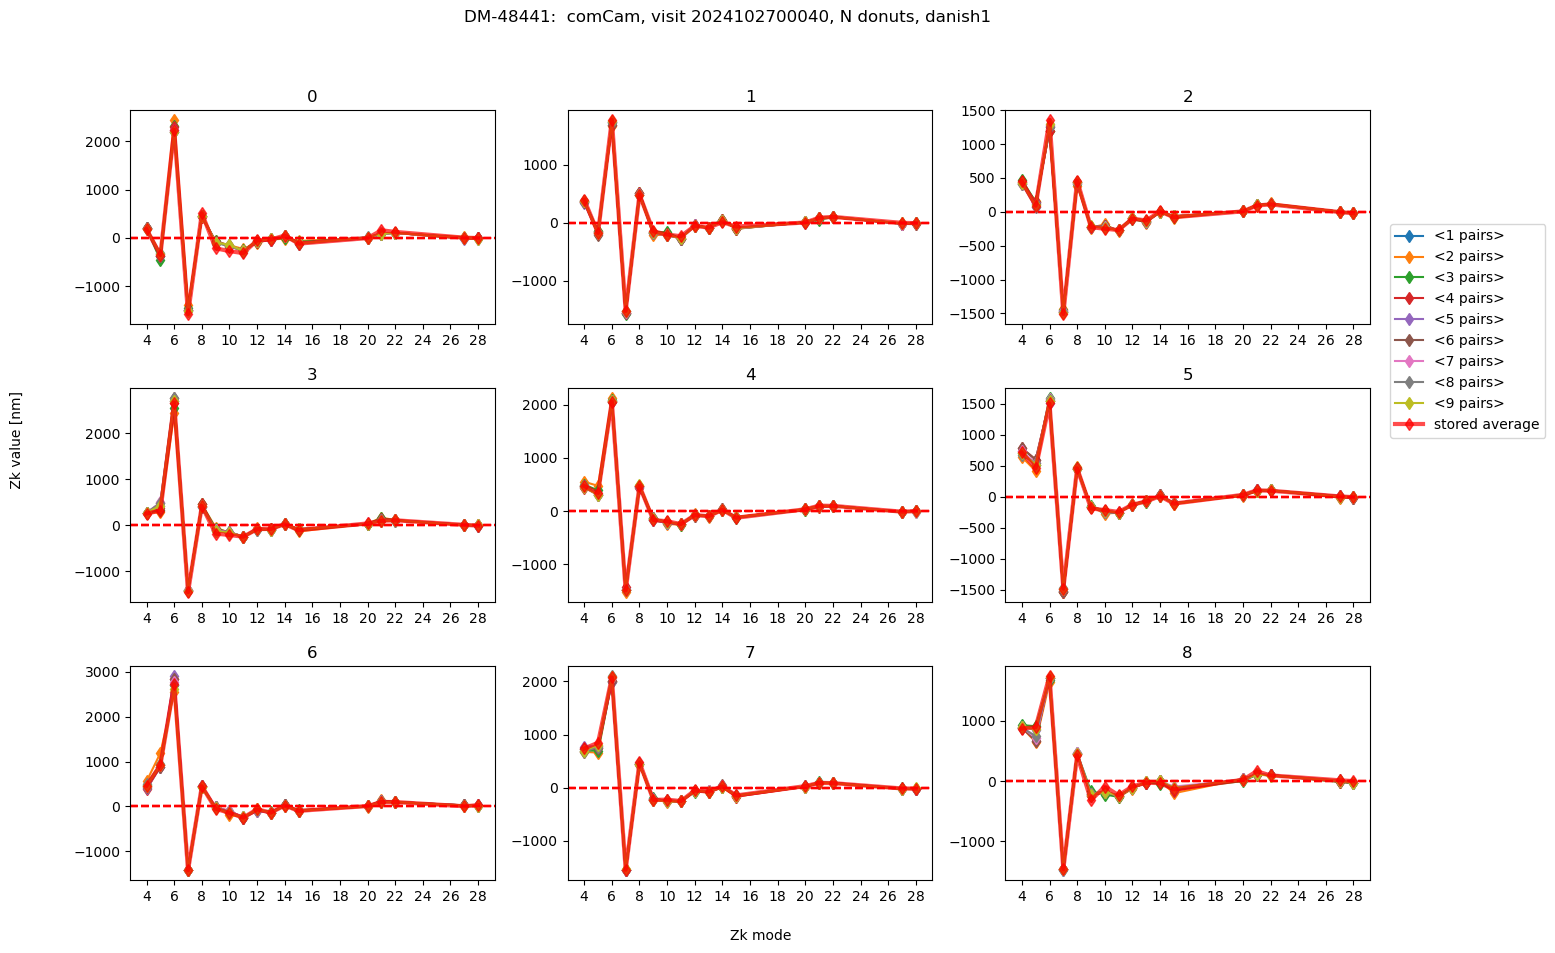

In [27]:
visit = visits_available[3]

Nmin = 1 

fig,axs = plt.subplots(3,3,figsize=(16,10))
ax = np.ravel(axs)
method = 'danish1'
for Nmax in range(1,10):
    results = results_visit[visit][method]
    
    # iterate over detectors 
    for i in range(9):
        zernikes_all = results[i] 
        
        # select only those donut pairs that were actually used 
        zernikes = zernikes_all[zernikes_all['used'] == True]
    
        if Nmax+1 <= len(zernikes):
            # Select row or a range of rows 
            rows = zernikes[Nmin:Nmax]
        
            # read off which modes were fitted 
            zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
            zk_modes = [int(col[1:]) for col in zk_cols]
            zk_fit_nm_median = [np.median(rows[col].value) for col in zk_cols]
            
            ax[i].plot(zk_modes, zk_fit_nm_median, marker='d', label=f'<{Nmax} pairs> ')
              
            ax[i].set_xticks(np.arange(4,29,step=2))
            ax[i].axhline(0,ls='--', c='red')
            
        else:
            raise ValueError(f'Nmax= {Nmax} > {len(zernikes)} ')

# Also plot the stored average value which is the 0th row 
for i in range(9):    
    # select zernikes for that detector
     zernikes = results_visit[visit][method][i] 
     ax[i].set_title(i)
    # select the average
     rows = zernikes[0]
     zk_fit_nm_median = [np.median(rows[col].value) for col in zk_cols]
     ax[i].plot(zk_modes, zk_fit_nm_median, marker='d', lw=3, c='red', label='stored average',
               alpha=0.7)
ax[2].legend(bbox_to_anchor = [1.5,0.5])


fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5,' Zk value [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, visit {visit}, N donuts, {method} ')

As we see, on an absolute scale the deviations are very small. Illustrate their range by plotting the deviation from the average using all 9 donuts:

Text(0.5, 0.98, 'DM-48441:  comCam, visit 2024102700040, N donuts, danish1 ')

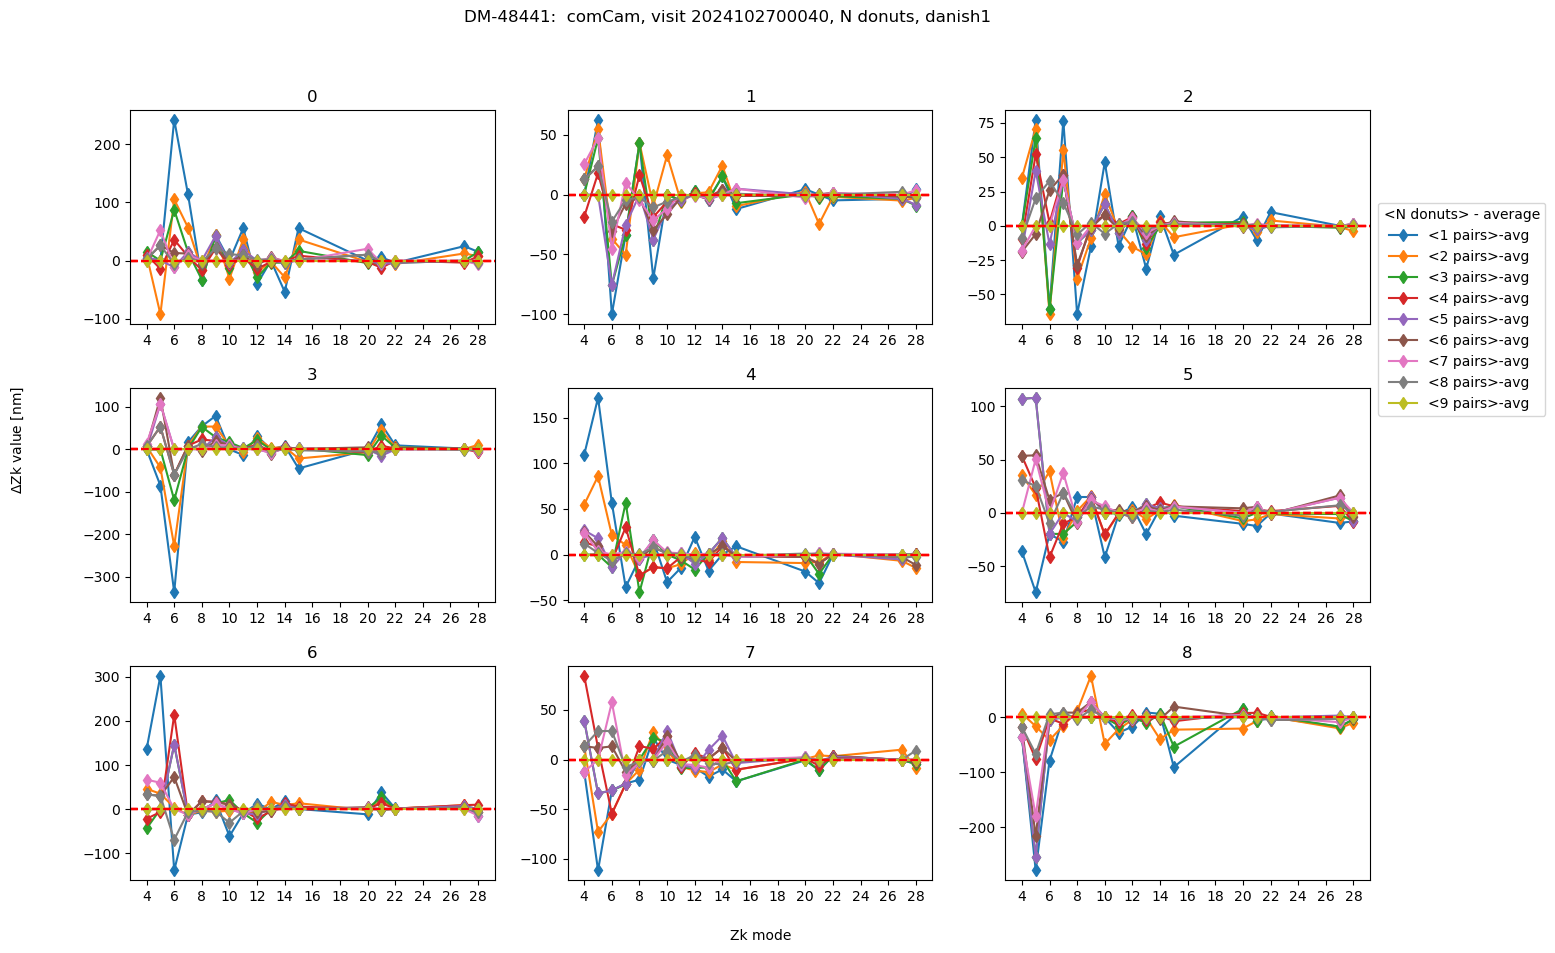

In [28]:
Nmin = 1 

fig,axs = plt.subplots(3,3,figsize=(16,10))
ax = np.ravel(axs)

for Nmax in range(1,10):
    # plot for  each detector just the first donut pair 
    for i in range(9):
        # read off which modes were fitted 
        zernikes_all = results_visit[visit][method][i] 
        
        # select only those zernikes that were actually used 
        zernikes = zernikes_all[zernikes_all['used'] == True]
        zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
        zk_modes = [int(col[1:]) for col in zk_cols]
        
        # Calculate the final average of N donut pairs 
        rows = zernikes[Nmin:10]
        zk_fit_nm_avg  = [np.median(rows[col].value) for col in zk_cols]
         
        if Nmax+1 <= len(zernikes):
            # Select row or a range of rows 
            rows = zernikes[Nmin:Nmax+1]
            
            # read off which modes were fitted 
            zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
            zk_modes = [int(col[1:]) for col in zk_cols]
            zk_fit_nm_median = [np.median(rows[col].value) for col in zk_cols]
            
            ax[i].plot(zk_modes, np.array(zk_fit_nm_median) - np.array(zk_fit_nm_avg), marker='d', label=f'<{Nmax} pairs>-avg ')
            ax[i].set_title(i)
            ax[i].set_xticks(np.arange(4,29,step=2))
            ax[i].axhline(0,ls='--', c='red')
           
        else:
            raise ValueError(f'Nmax= {Nmax} > {len(zernikes)} ')

ax[2].legend(bbox_to_anchor=[1.5,0.6], title='<N donuts> - average')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5,  r'$\Delta$'+'Zk value [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, visit {visit}, N donuts, {method} ')

We can summarize that by plotting for each visit the RMS difference between average using N-donut pairs (with N:1,2,3,4, etc) and N=9 (final average). This corresponds to the speed of convergence to the final result:

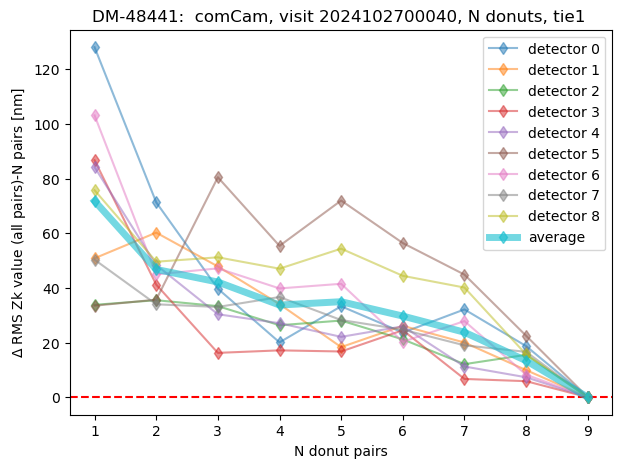

In [29]:
Nmin = 1  # row 0 is the average 
NmaxValue = 10 
method = 'tie1'

fig,ax = plt.subplots(1,1,figsize=(7,5))

per_det = []
# iterate over detectors 
for i in range(9):
    zernikes = results_visit[visit][method][i]  

    # read the available names of Zk mode columns
    zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
    zk_modes = [int(col[1:]) for col in zk_cols]

    # Calculate the final average of N donut pairs 
    rows = zernikes[Nmin:NmaxValue]
    zk_fit_nm_avg  = [np.median(rows[col].value) for col in zk_cols]
    rms_diffs_per_det = []
    
    # iterate over how many donut pairs to include in the average 
    for Nmax in range(1,NmaxValue):

        if Nmax+1 <= len(zernikes):
            # Select row or a range of rows 
            rows = zernikes[Nmin:Nmin+Nmax]
        
            # read off which modes were fitted 
            zk_fit_nm_median = [np.median(rows[col].value) for col in zk_cols]

            rms_diff =  np.sqrt(
                    np.mean(
                            np.square(
                                        np.array(zk_fit_nm_avg) - np.array(zk_fit_nm_median)
                                     )
                           )
                   )
            rms_diffs_per_det.append(rms_diff)
           
        else:
            raise ValueError(f'Nmax= {Nmax} > {len(zernikes)} ')
    per_det.append(rms_diffs_per_det)

    # plot the RMS diff for each detector
    ax.plot(range(Nmin,NmaxValue), rms_diffs_per_det, marker='d', label=f'detector {i}', alpha=0.5)

ax.set_xticks(range(Nmin,NmaxValue))
ax.axhline(0,ls='--', c='red')

# Plot detector average
ax.plot(range(Nmin, NmaxValue), np.mean(per_det, axis=0), marker='d', lw=5, alpha=0.6,  label='average' )


ax.set_xlabel('N donut pairs')
ax.set_ylabel(r'$\Delta$ RMS'+' Zk value (all pairs)-N pairs [nm]', )
ax.set_title(f'DM-48441:  comCam, visit {visit}, N donuts, {method} ')
ax.legend()

We can calculate this metric for all visits, expressing RMS in both nm and asec:

In [ ]:
# calculation of RMS diff 
Nmin=1
NmaxValue = 10 

rms_visit = {}
rms_visit_asec = {}
count =0 
for visit in tqdm(visits_available, desc='Calculating'):
    rms_diffs = {}
    rms_diffs_asec = {}
    for  method  in results_visit[visit].keys():
        results = results_visit[visit][method]
        rms_diffs[method] = {}
        rms_diffs_asec[method] = {}
        for i in range(9):
            zernikes_all = results[i] 
            # select only those zernikes that were actually used 
            zernikes = zernikes_all[zernikes_all['used'] == True]
            
            # read the available names of Zk mode columns
            zk_cols = [col for col in zernikes.columns if col.startswith('Z')]

            # read off which modes were fitted 
            zk_modes = [int(col[1:]) for col in zk_cols]
            
            # select not the stored average,
            # but calculate average using all available donuts
            all_rows = zernikes[Nmin:NmaxValue]
            zk_fit_avg_nm  = [np.median(all_rows[col].value) for col in zk_cols]
            zk_fit_avg_nm_dense = makeDense(zk_fit_avg_nm, zk_modes)
            zk_fit_avg_asec_dense = convertZernikesToPsfWidth(1e-3*zk_fit_avg_nm_dense)
            zk_fit_avg_asec = makeSparse(zk_fit_avg_asec_dense, zk_modes)
            
            rms_diffs_per_det = []
            rms_diffs_per_det_asec = []
            
            # iterate over how many donut pairs to include in the average 
            for Nmax in range(1,NmaxValue):
        
                if Nmax <= len(zernikes):
                    # Select row or a range of rows 
                    rows = zernikes[Nmin:Nmin+Nmax]
                    zk_fit_median_nm = [np.median(rows[col].value) for col in zk_cols]
                    zk_fit_median_nm_dense = makeDense(zk_fit_median_nm, zk_modes)
                    zk_fit_median_asec_dense = convertZernikesToPsfWidth(1e-3*zk_fit_median_nm_dense)
                    zk_fit_median_asec = makeSparse(zk_fit_median_asec_dense, zk_modes)
                    
                    rms_diff =  np.sqrt(
                            np.mean(
                                    np.square(
                                                np.array(zk_fit_avg_nm) - np.array(zk_fit_median_nm)
                                             )
                                   )
                           )

                    rms_diff_asec =  np.sqrt(
                            np.mean(
                                    np.square(
                                                np.array(zk_fit_avg_asec) - np.array(zk_fit_median_asec)
                                             )
                                   )
                    )
                    rms_diffs_per_det.append(rms_diff)
                    rms_diffs_per_det_asec.append(rms_diff_asec)
            #print(i, visit, len(rms_diffs_per_det), rms_diffs_per_det[-1])
            rms_diffs[method][i] = rms_diffs_per_det
            rms_diffs_asec[method][i] = rms_diffs_per_det_asec
    # store the results for both methods per visit 
    rms_visit[visit] = rms_diffs
    rms_visit_asec[visit] = rms_diffs_asec
    count +=1 

Nvisits = len(visits_available)
file = f'u_scichris_aosBaseline_tie_danish_rms_visit_{Nvisits}.npy'
np.save(file, rms_visit, allow_pickle=True)
file = f'u_scichris_aosBaseline_tie_danish_rms_visit_asec_{Nvisits}.npy'
np.save(file, rms_visit_asec, allow_pickle=True)


Now, for each visit there is a comparison for different calculation methods and binning used:

Text(0.5, 0.98, 'DM-48441:  comCam, visit 2024102700017, N donuts, all methods ')

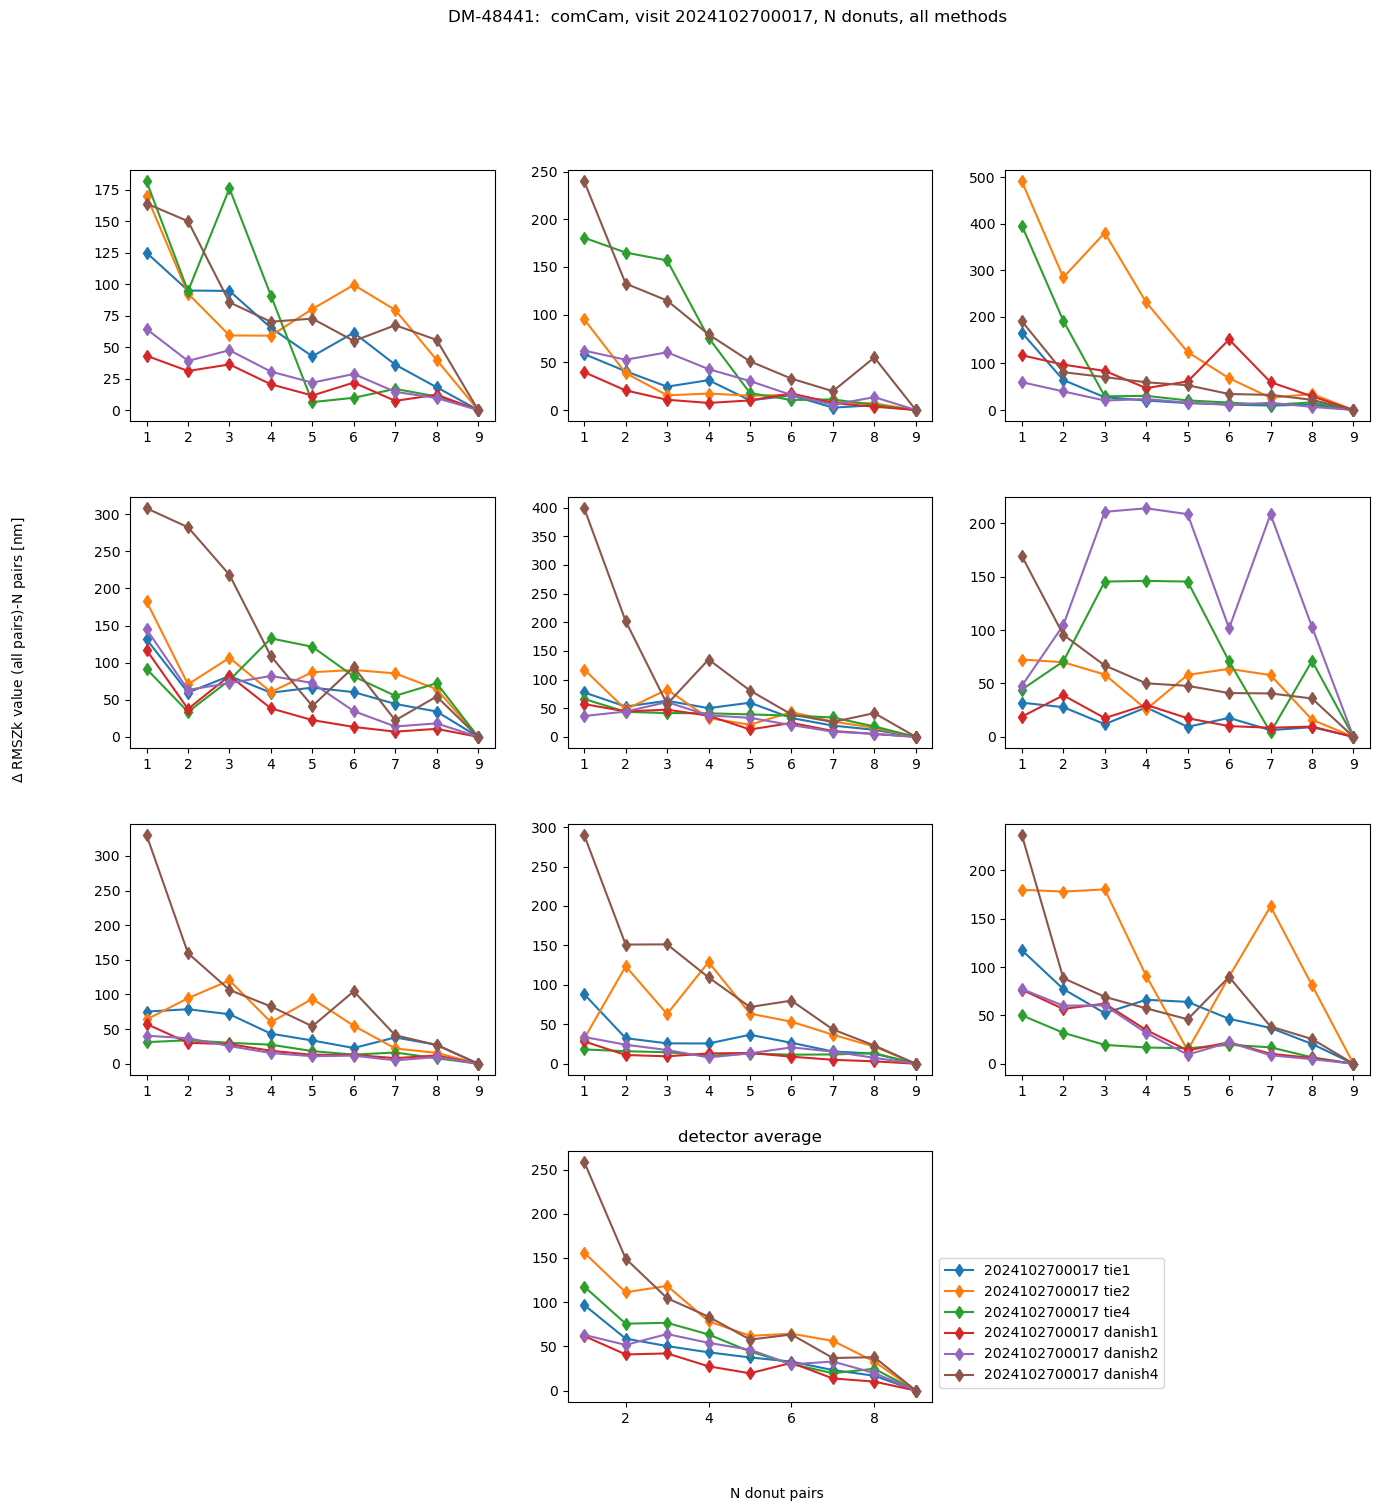

In [53]:
# plotting         
Nmin = 1 

fig,axs = plt.subplots(4,3,figsize=(16,16))
ax = np.ravel(axs)


visit = list(rms_visit.keys())[0]

for  method  in rms_visit[visit].keys():
    per_det = []
    # iterate over detectors 
    for i in range(9):
        # plot the RMS diff for each detector
        rms_per_det =  rms_visit[visit][method][i]
        
        ax[i].plot(range(1,len(rms_per_det)+1), rms_per_det, marker='d', label=f'{visit} {method}')
        ax[i].set_xticks(np.arange(1,10, step=1))

        per_det.append(rms_per_det)

    ax[10].plot(range(1,len(rms_per_det)+1), np.mean(np.asarray(per_det), axis =0),  marker='d', label=f'{visit} {method}')
     
ax[10].legend(bbox_to_anchor=[1.,0.6], title='')

ax[9].axis('off')

ax[10].set_title('detector average')
ax[11].axis('off')
        
            
fig.text(0.5,0.05, 'N donut pairs')
fig.text(0.05,0.5,  r'$\Delta$ RMS'+'Zk value (all pairs)-N pairs [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, visit {visit}, N donuts, all methods ')

This rapidity of convergence can be summarized for each binning by taking an average across all visits:

In [51]:
file = f'u_scichris_aosBaseline_tie_danish_rms_visit_604.npy'
rms_visit = np.load(file, allow_pickle=True).item()
file = f'u_scichris_aosBaseline_tie_danish_rms_visit_asec_604.npy'
rms_visit_asec = np.load(file, allow_pickle=True).item()

all_visits_rms_per_method = {}
for method in results_visit[visit].keys():
    all_visits_rms_per_det = {}
    for i in range(9): 
        all_visits_rms_per_det[i] = []
        for visit in rms_visit.keys():
          
          # plot the RMS diff for each detector
          rms_per_det =  rms_visit[visit][method][i]

          if len(rms_per_det) == 9:
            all_visits_rms_per_det[i].append(rms_per_det)
    all_visits_rms_per_method[method] = all_visits_rms_per_det

all_visits_rms_per_method_asec = {}
for method in results_visit[visit].keys():
    all_visits_rms_per_det_asec = {}
    for i in range(9): 
        all_visits_rms_per_det_asec[i] = []
        for visit in rms_visit_asec.keys():
          
          # plot the RMS diff for each detector
          rms_per_det =  rms_visit_asec[visit][method][i]

          if len(rms_per_det) == 9:
            all_visits_rms_per_det_asec[i].append(rms_per_det)
    all_visits_rms_per_method_asec[method] = all_visits_rms_per_det_asec

Text(0.5, 0.98, 'DM-48441:  comCam, N donuts, TIE & Danish different binning ')

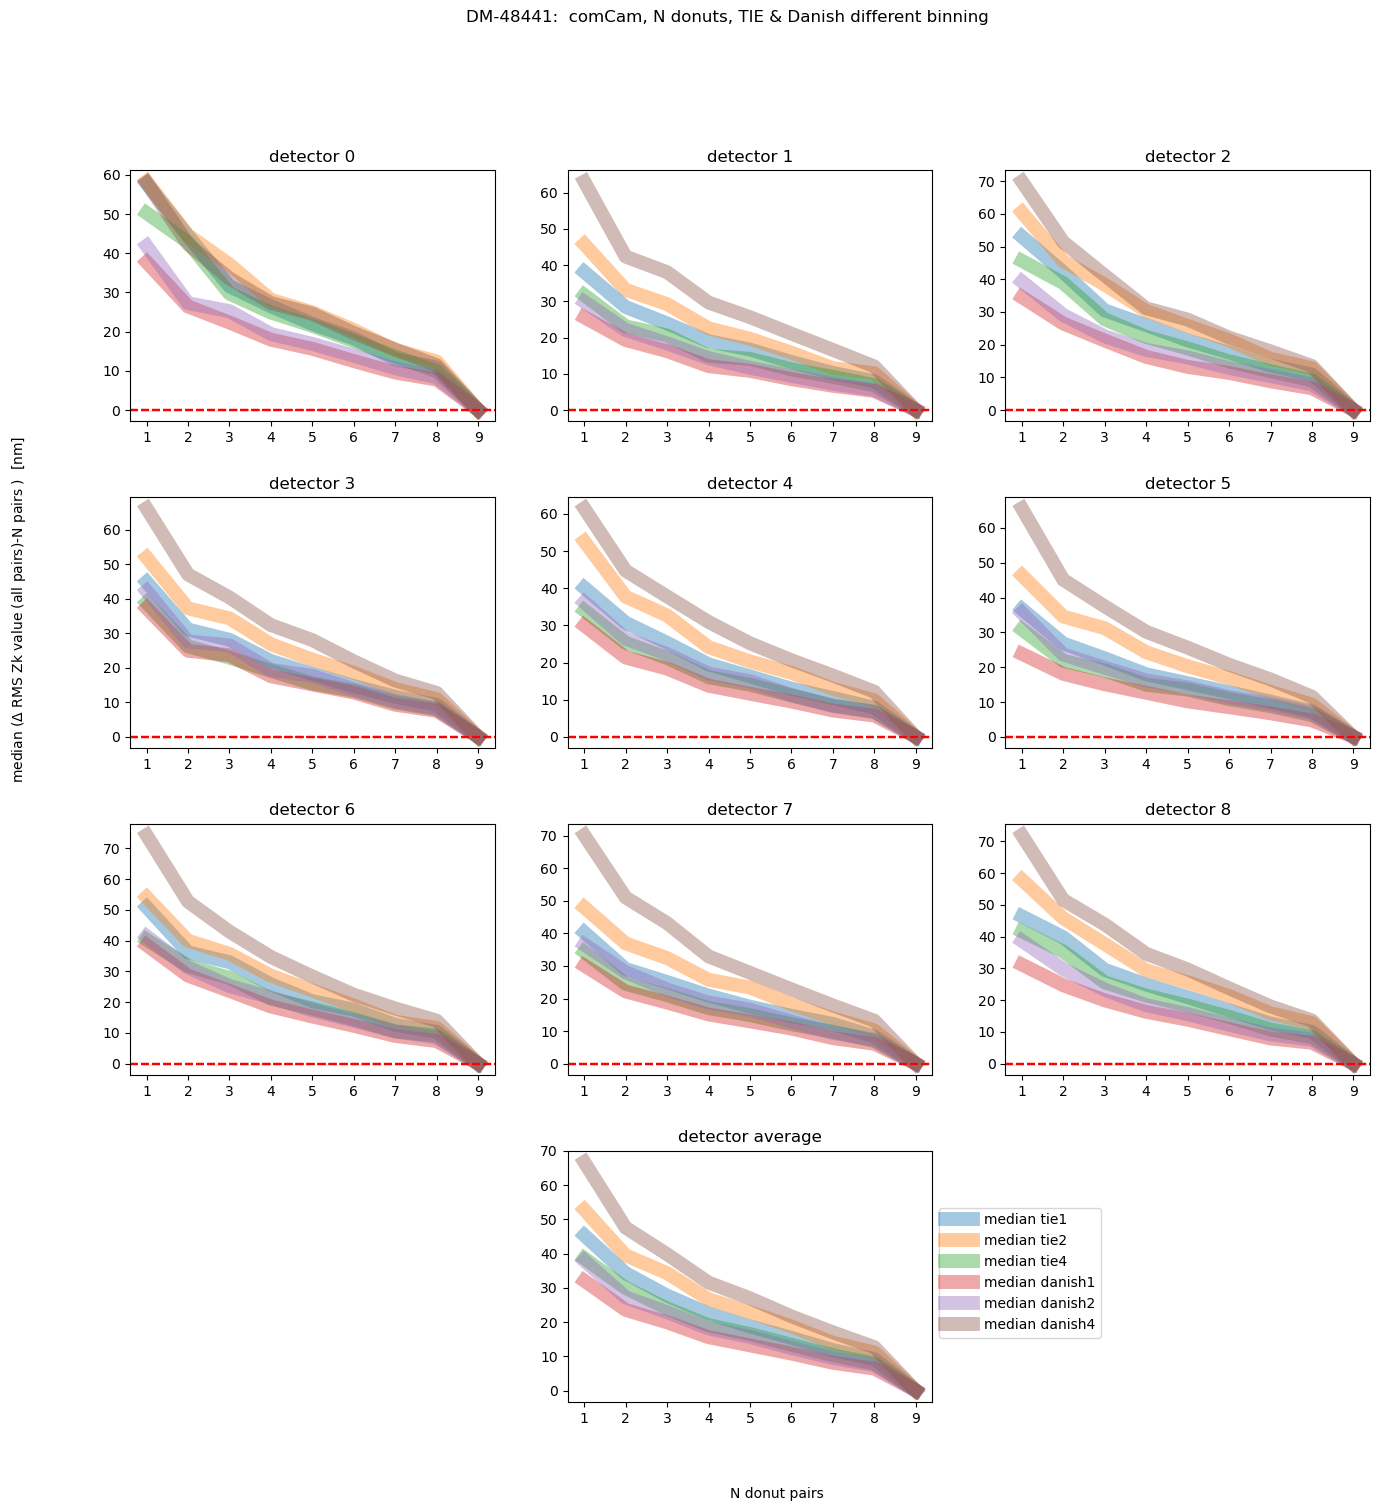

In [52]:
Nvisits = len(list(rms_visit.keys()))
fig,axs = plt.subplots(4,3,figsize=(16,16))
ax = np.ravel(axs)
for method in results_visit[visit].keys():
    y_data = []
    x_data = range(1,10)
    for i in range(9):
        per_det_med =  np.nanmedian(all_visits_rms_per_method[method][i], axis=0)
        ax[i].plot(x_data,per_det_med, lw = 10, alpha=0.4,
                  label=f'median {method}')
        ax[i].axhline(0,ls='--', c='red')
        ax[i].set_xticks(np.arange(1,10, step=1))
        ax[i].set_title(f'detector {i}')
        y_data.append(per_det_med)

    ax[10].plot(x_data, np.mean(y_data, axis=0), lw = 10, alpha=0.4,
                  label=f'median {method}')
    ax[10].set_xticks(np.arange(1,10, step=1))
ax[10].legend(bbox_to_anchor=[1.,0.8], title='')
ax[10].set_title('detector average')
ax[9].axis('off')
ax[11].axis('off')
        

fig.text(0.5,0.05, 'N donut pairs')
fig.text(0.05,0.5,  'median ('+ r'$\Delta$ RMS'+' Zk value (all pairs)-N pairs )  [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, N donuts, TIE & Danish different binning ')

Text(0.5, 0.98, 'DM-48441:  comCam, N donuts, TIE & Danish different binning ')

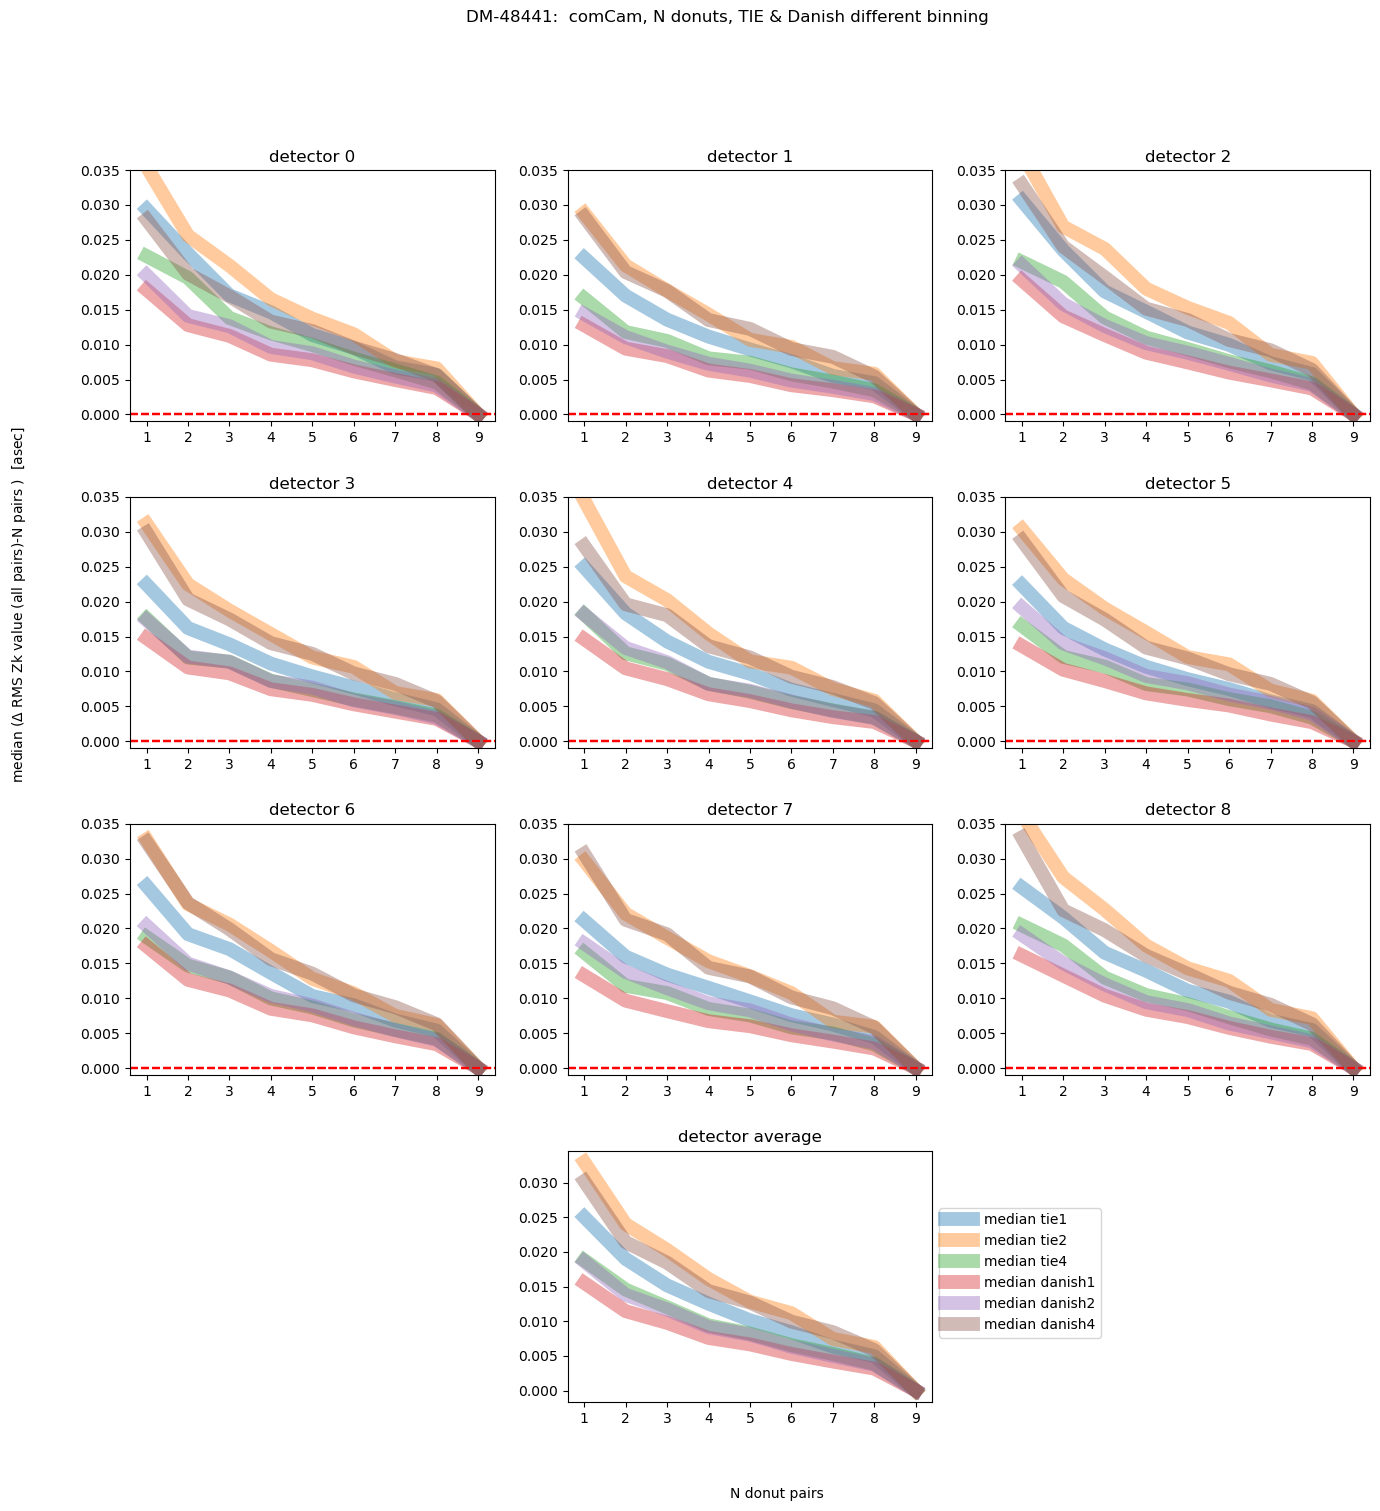

In [53]:
Nvisits = len(list(rms_visit.keys()))
fig,axs = plt.subplots(4,3,figsize=(16,16))
ax = np.ravel(axs)
for method in results_visit[visit].keys():

    y_data = []
    x_data = range(1,10)
    for i in range(9):
        per_det_median = np.nanmedian(all_visits_rms_per_method_asec[method][i], axis=0) 
        ax[i].plot(x_data, per_det_median, lw = 10, alpha=0.4,
                  label=f'median {method}')
        ax[i].set_xticks(np.arange(1,10, step=1))
        ax[i].set_ylim(-0.001, 0.035)
        ax[i].axhline(0,ls='--', c='red')
        
        ax[i].set_title(f'detector {i}')
        y_data.append(per_det_median)
        
    ax[10].plot(x_data, np.mean(y_data, axis=0), lw = 10, alpha=0.4,
                  label=f'median {method}')
    ax[10].set_xticks(np.arange(1,10, step=1))    
ax[10].legend(bbox_to_anchor=[1.,0.8], title='')
ax[10].set_title('detector average')
ax[9].axis('off')
ax[11].axis('off')
            
fig.text(0.5,0.05, 'N donut pairs')
fig.text(0.05,0.5,  'median ('+ r'$\Delta$ RMS'+' Zk value (all pairs)-N pairs )  [asec]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, N donuts, TIE & Danish different binning ')

This shows us that, on average, Danish even with 2x binning achieves the final answer with less initial deviation than TIE. We can also plot different magnitude ranges: 

In [54]:
file = f'u_scichris_aosBaseline_tie_danish_mag_visit_604.npy'
results_visit_mags = np.load(file , allow_pickle=True).item()

In [55]:
visits  = []
visit_mean_mag = [] 

Ndonuts = 9  # we take the mean only of the fisrt 9 donuts 
for visit in results_visit_mags.keys():
    mean_per_det = []
    for detector in range(9):
        mags = results_visit_mags[visit][detector]['donutStampsExtraMag']
        if len(mags) < Ndonuts:

            mean_mag_per_det = np.mean(mags[:len(mags)])
            
        else:
            mean_mag_per_det = np.mean(mags[:Ndonuts])
        results_visit_mags[visit][detector][f'mean_{Ndonuts}_donuts']= mean_mag_per_det
        mean_per_det.append(mean_mag_per_det)
    visits.append(int(visit))
    visit_mean_mag.append(np.mean(mean_per_det))

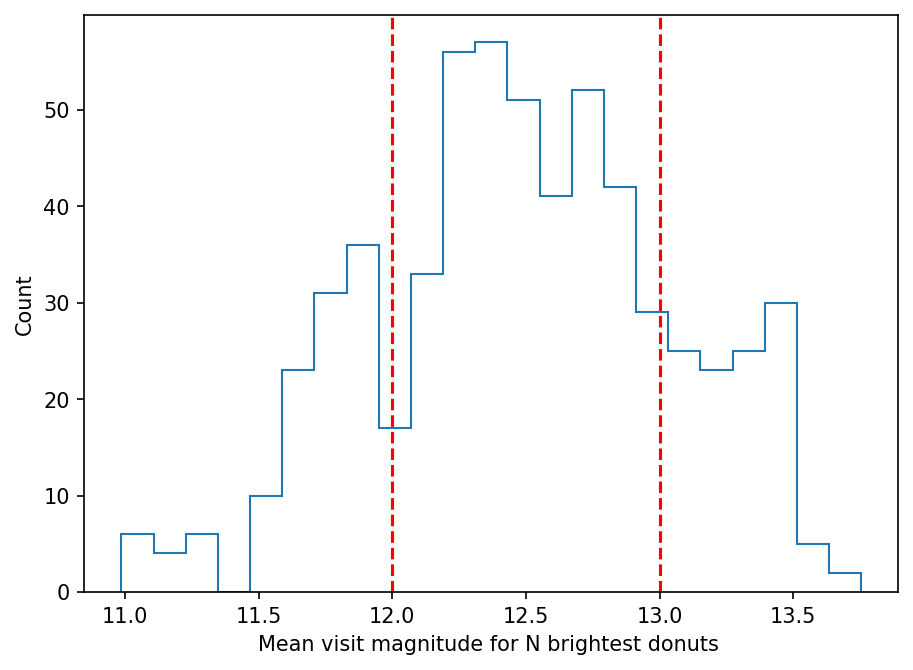

In [69]:
fig = plt.figure(figsize=(7,5), dpi=150)

plt.hist(visit_mean_mag, histtype='step', bins=23)
plt.ylabel('Count')
plt.xlabel('Mean visit magnitude for N brightest donuts ')
plt.axvline(12, ls='--',c='red')
plt.axvline(13, ls='--',c='red')

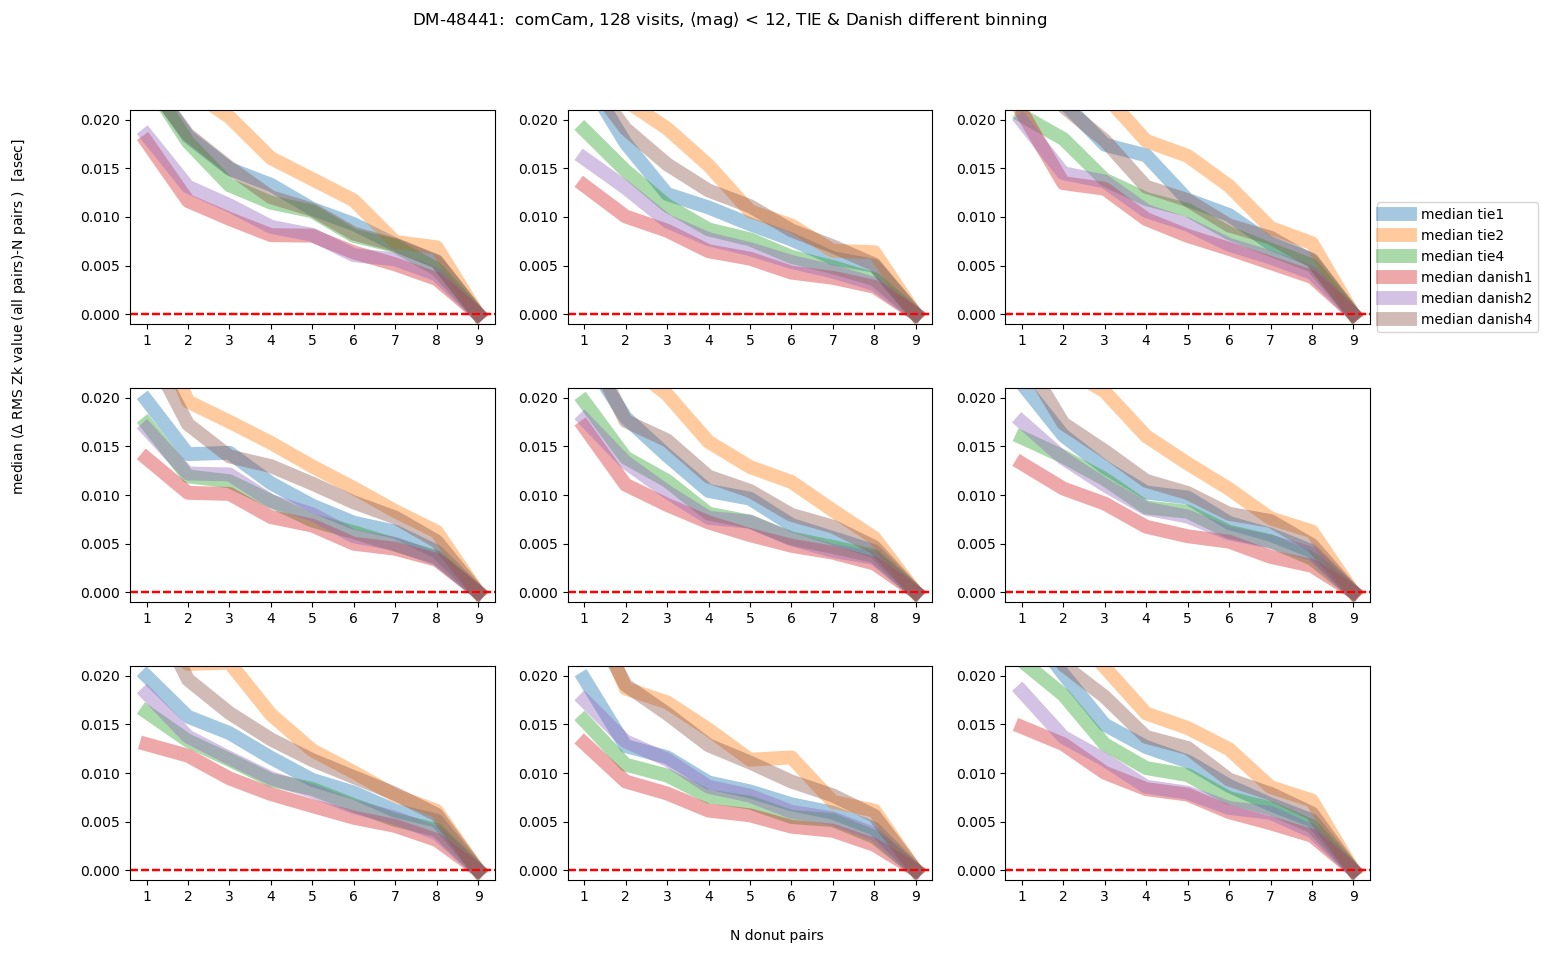

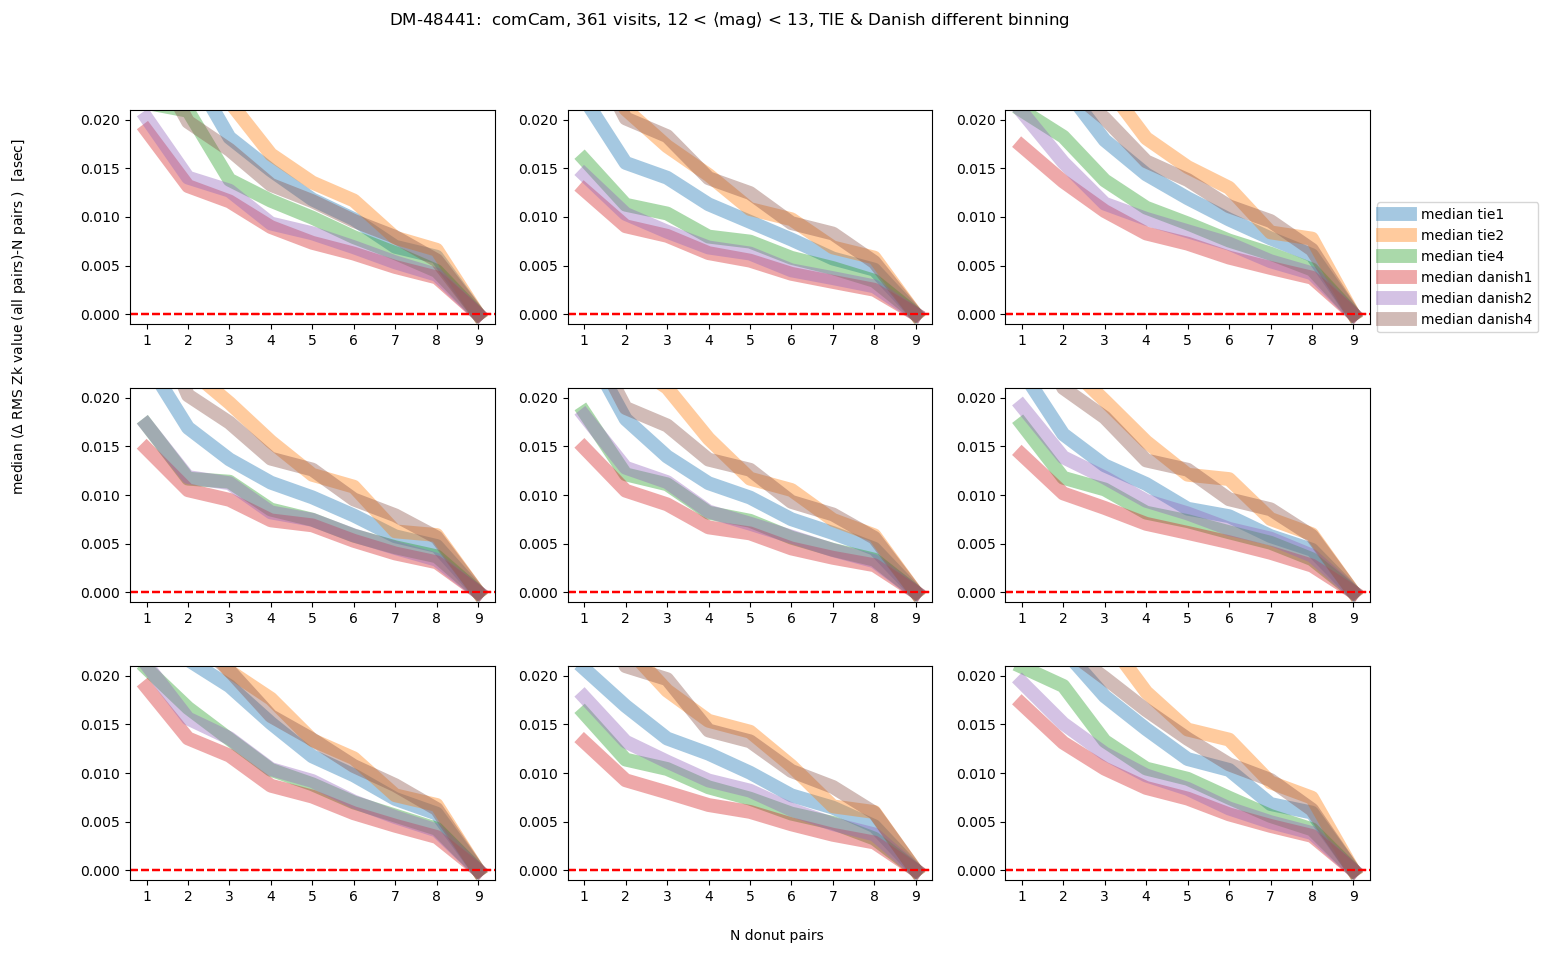

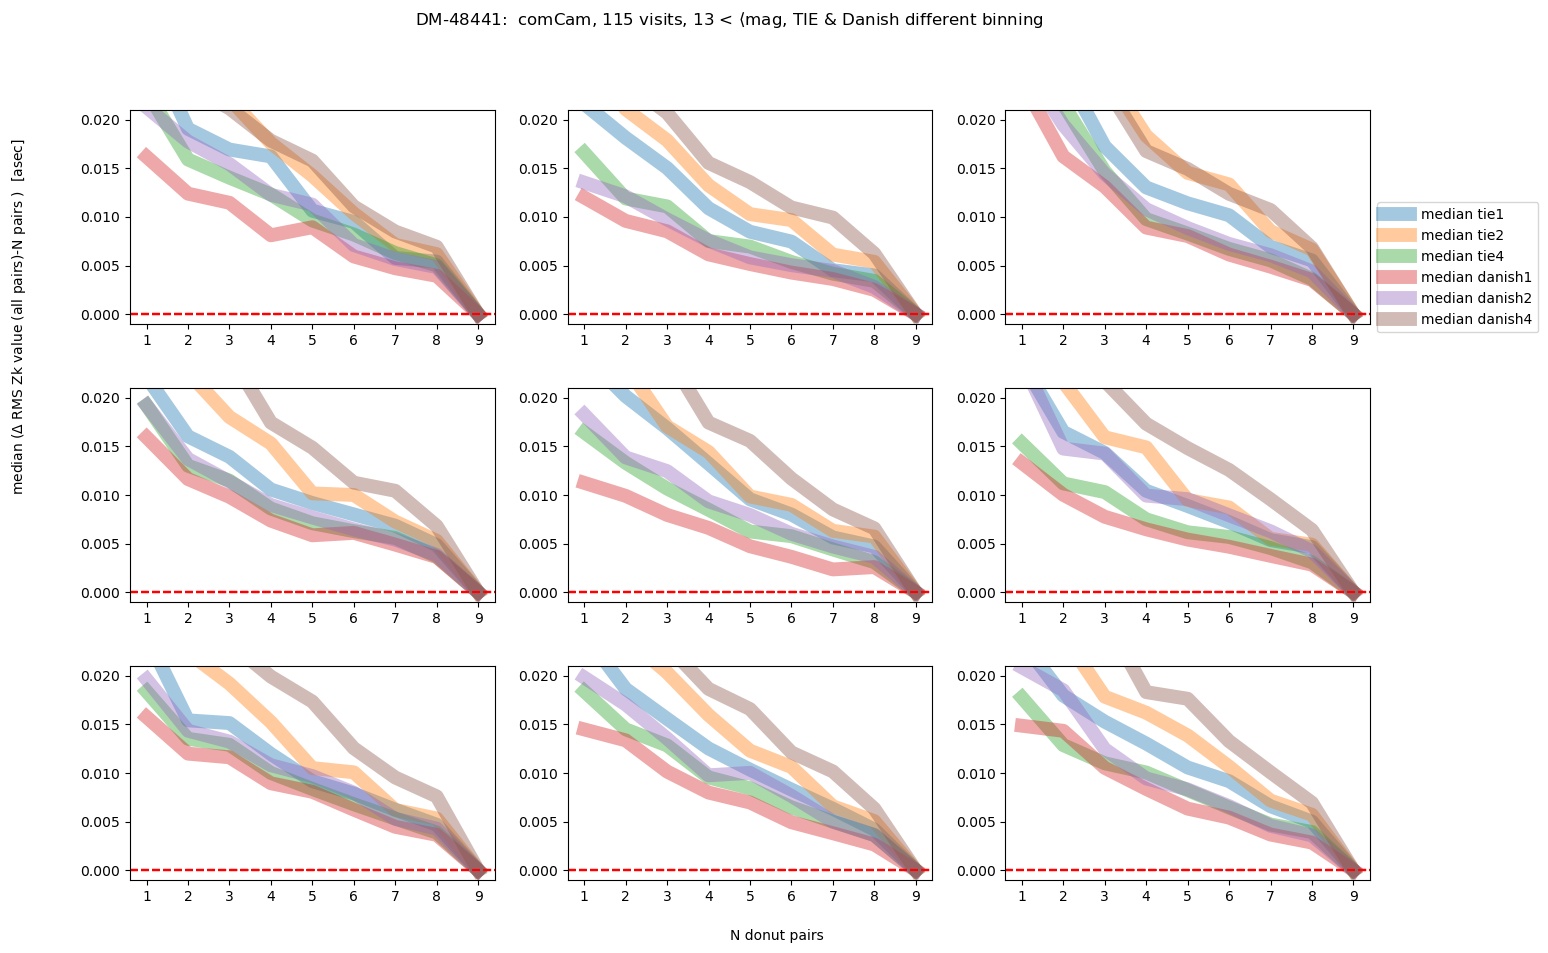

In [77]:
mag_ranges = [0,12,13,20]

mag_labels = [r'$\langle$'+'mag'+r'$\rangle$'+' < 12',
              '12 < '+r'$\langle$'+'mag'+r'$\rangle$'+' < 13',
              '13 < '+r'$\langle$'+'mag'
]

for idx in range(len(mag_ranges)-1):
    mag_min = mag_ranges[idx]
    mag_max = mag_ranges[idx+1]
    selected_visits = np.array(visits)[(mag_min < np.array(visit_mean_mag) ) * (np.array(visit_mean_mag) < mag_max)]
    all_visits_rms_per_method_asec = {}
    for method in results_visit[visit].keys():
        all_visits_rms_per_det_asec = {}
        for i in range(9): 
            all_visits_rms_per_det_asec[i] = []
            for visit in selected_visits:
              
              # plot the RMS diff for each detector
              rms_per_det =  rms_visit_asec[visit][method][i]
              if len(rms_per_det) == 9:
                all_visits_rms_per_det_asec[i].append(rms_per_det)
        all_visits_rms_per_method_asec[method] = all_visits_rms_per_det_asec
    
    Nvisits = len(list(selected_visits))
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)
    for method in results_visit[visit].keys():
        for i in range(9):
            ax[i].plot(range(1,10), np.nanmedian(all_visits_rms_per_method_asec[method][i], axis=0), lw = 10, alpha=0.4,
                      label=f'median {method}')
            ax[i].set_ylim(-0.001, 0.021)
            ax[i].axhline(0,ls='--', c='red')
            ax[i].set_xticks(np.arange(1,10, step=1))
        #ax[i].legend()
    ax[2].legend(bbox_to_anchor=[1.,0.6], title='')
    fig.text(0.5,0.05, 'N donut pairs')
    fig.text(0.05,0.5,  'median ('+ r'$\Delta$ RMS'+' Zk value (all pairs)-N pairs )  [asec]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'DM-48441:  comCam, {Nvisits} visits, '+mag_labels[idx]+ ', TIE & Danish different binning ')

As we would expect, the brighter the donuts, the quicker the convergence to the final answer.  Danish with (red and purple lines) outperforms TIE for edge detectors, but for center detector Danish with x2 binning achieves similar performance as TIE. Note however, that the "final answer" may be different for each binning, as each binning results in a slightly different wavefront estimation. In the next section we address what is the difference between the average of 9 donut  pairs for each binning method.

## Median of N donuts: same visit, different binning

To compare Zernikes for the same visit but different binning levels, we average across 9 brightest donuts per detector:


In [56]:
fname = f'u_scichris_aosBaseline_tie_danish_zernikes_tables_604.npy'
results_visit = np.load(fname, allow_pickle=True).item()

Text(0.5, 0.98, 'DM-48441:  comCam, visit 2024102500123, N donuts, all methods ')

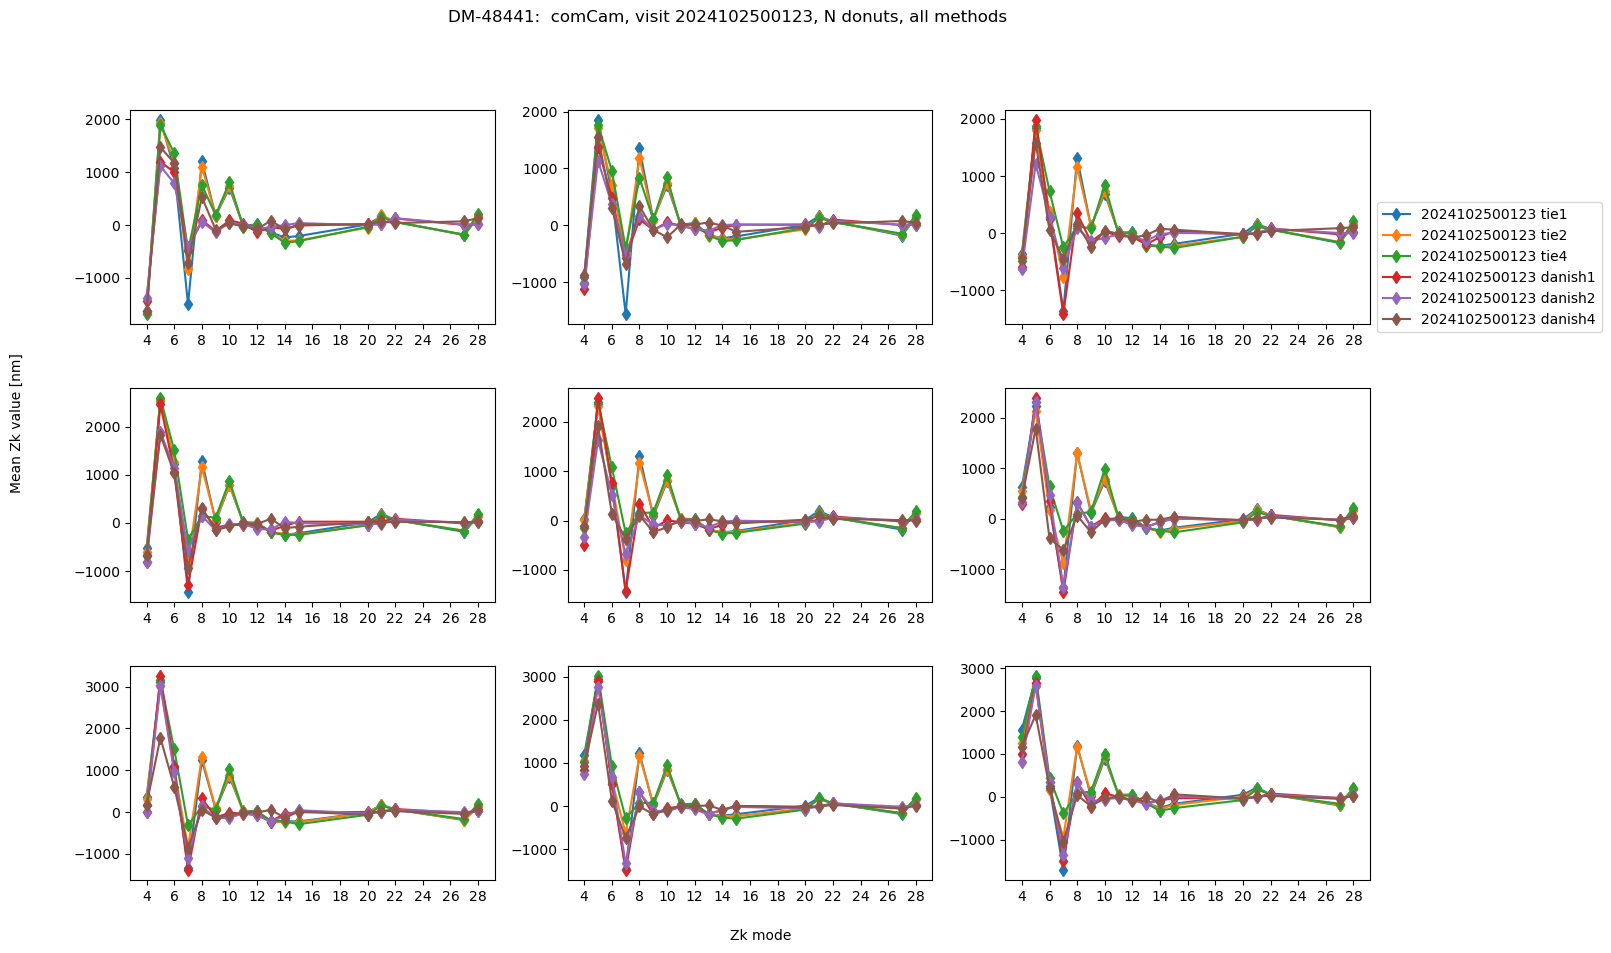

In [19]:
# plotting         
Nmin = 1 
Nmax = 10
fig,axs = plt.subplots(3,3,figsize=(16,10))
ax = np.ravel(axs)

visit = list(results_visit.keys())[2]

for method in results_visit[visit].keys():
    results = results_visit[visit][method]
    # iterate over detectors 
    for i in range(9):
        zernikes_all = results[i] 
        # select only those zernikes that were actually used 
        zernikes = zernikes_all[zernikes_all['used'] == True]
        
        # read the available names of Zk mode columns
        zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
        zk_modes = [int(col[1:]) for col in zk_cols]
        
        # select not the stored average, which uses potentially all donuts
        # per detector, but instead calculate average using all available donuts
        all_rows = zernikes[Nmin:Nmax]
        zk_fit_nm_median = [np.median(all_rows[col].value) for col in zk_cols]
        
        ax[i].plot(zk_modes, np.array(zk_fit_nm_median), marker='d', label=f'{visit} {method}')
        ax[i].set_xticks(np.arange(4,29,step=2))
   
    
ax[2].legend(bbox_to_anchor=[1.,0.6], title='')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5,  r'Mean Zk value [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, visit {visit}, N donuts, all methods ')

We find the RMS difference between average of 9 donut pairs with no binning, vs various binning settings. 



In [58]:
def find_avg_zernikes_N_pairs(zernikes_all, Nmin=0, Nmax=10):

    # select only those zernikes that were actually used 
    zernikes = zernikes_all[zernikes_all['used'] == True]
    
    # read the available names of Zk mode columns
    zk_cols = [col for col in zernikes.columns if col.startswith('Z')]
    
    # select not the stored average,
    # but calculate average using all available donuts

    all_rows = zernikes[Nmin:Nmax]
    zk_fit_nm_avg  = [np.median(all_rows[col].value) for col in zk_cols]

    return zk_fit_nm_avg

In [59]:
# calculation of RMS diff 
Nmin=0

zk_diff_tie_danish = {}
for met in ['tie', 'danish']:
    zk_diff_all_visits = {}
    count =0 
    for visit in tqdm(visits_available):
        zk_diff_per_visit = {}
        for method  in [f'{met}2', f'{met}4']:
            results_binned = results_visit[visit][method]
            results_base = results_visit[visit][f'{met}1']
            
            zk_diff_per_visit[method] = {}
            for i in range(9):
                # Find the mean for the baseline method 
                zk_fit_nm_avg_base  = find_avg_zernikes_N_pairs(results_base[i])
                zk_fit_nm_avg_base_dense = makeDense(zk_fit_nm_avg_base, zk_modes)
                zk_fit_asec_base_dense = convertZernikesToPsfWidth(1e-3*zk_fit_nm_avg_base_dense)
                zk_fit_asec_base_sparse = makeSparse(zk_fit_asec_base_dense, zk_modes)
                
                # Find the mean for the binned method 
                zk_fit_nm_avg_binned  = find_avg_zernikes_N_pairs(results_binned[i])
                zk_fit_nm_avg_binned_dense = makeDense(zk_fit_nm_avg_binned, zk_modes)
                zk_fit_asec_binned_dense =  convertZernikesToPsfWidth(1e-3*zk_fit_nm_avg_binned_dense)
                zk_fit_asec_binned_sparse = makeSparse(zk_fit_asec_binned_dense, zk_modes)
                
                # Calculate the RMS difference between the two 
                rms_diff =  np.sqrt(
                                np.mean(
                                        np.square(
                                                    np.array(zk_fit_nm_avg_base) - np.array(zk_fit_nm_avg_binned)
                                                 )
                                       )
                               )
                # Calculate the same in ASEC 
                rms_diff_asec =  np.sqrt(
                                np.mean(
                                        np.square(
                                                    np.array(zk_fit_asec_base_sparse) - np.array(zk_fit_asec_binned_sparse)
                                                 )
                                       )
                               )
                
                # Store both the per-mode differences and the RMS which is a single 
                # number per visit - detector 
                zk_diff_per_visit[method][i] = {'zk_no_binning_avg': zk_fit_nm_avg_base,
                                               'zk_with_binning_avg':zk_fit_nm_avg_binned,
                                                'zk_no_binning_avg_asec':zk_fit_asec_base_sparse,
                                                'zk_with_binning_avg_asec':zk_fit_asec_binned_sparse,
                                               'rms_diff':rms_diff,
                                                'rms_diff_asec':rms_diff_asec
                                               }
        # store the results for both methods per visit 
        zk_diff_all_visits[visit] = zk_diff_per_visit
        count +=1 
    zk_diff_tie_danish[met] = zk_diff_all_visits  


100%|██████████| 572/572 [00:35<00:00, 16.00it/s]


We plot the difference between baseline for single visit: 

Text(0.5, 0.98, 'DM-48441:  comCam, visit 2024121100565, N donuts, danish binning x1, x2, x4 ')

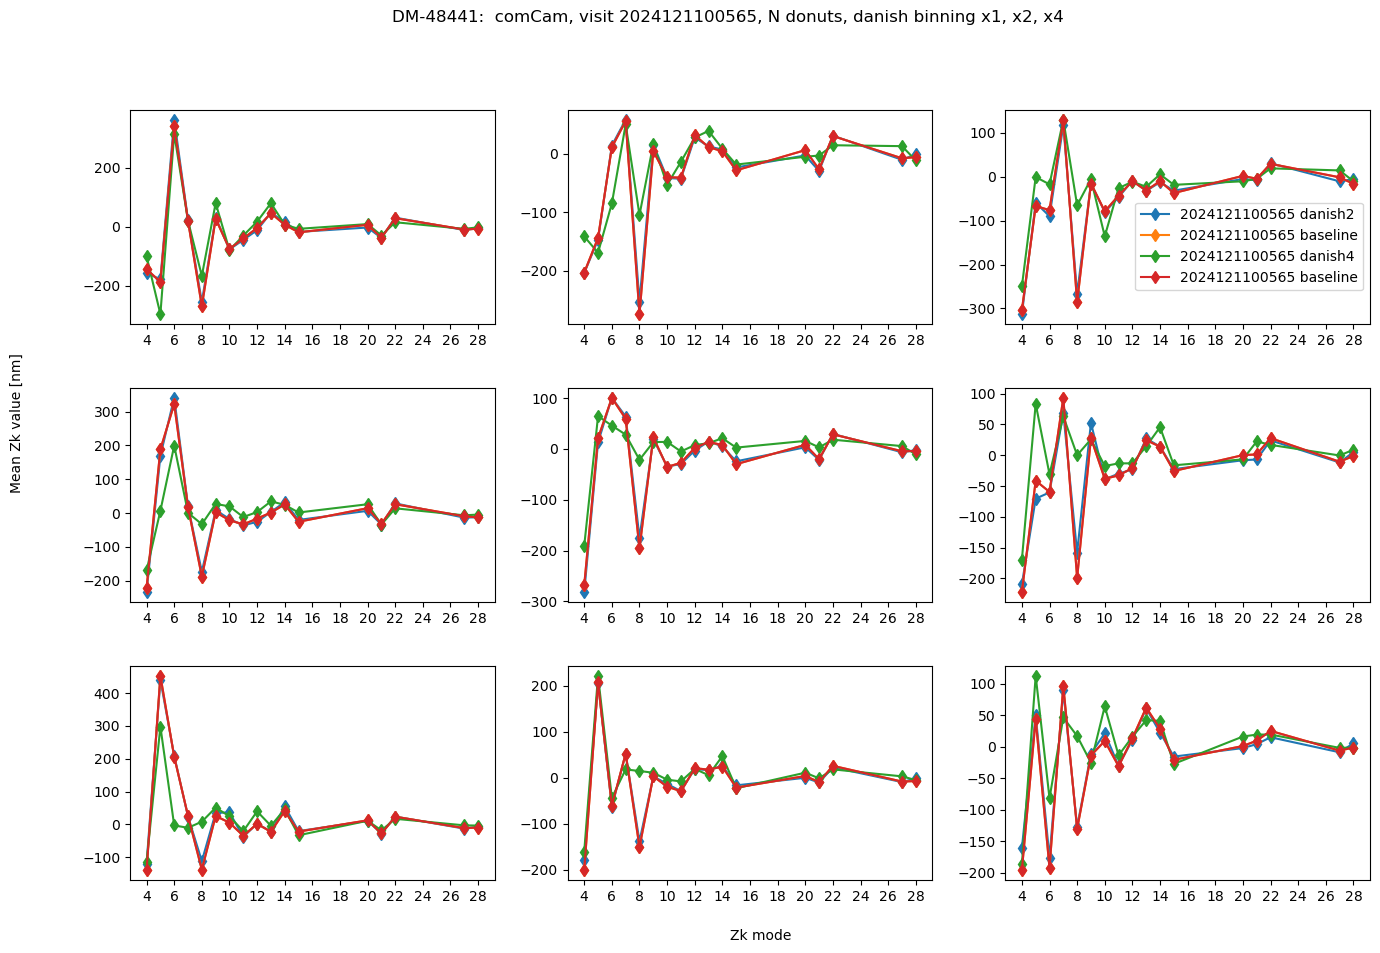

In [60]:
# plotting         
Nmin = 1 

fig,axs = plt.subplots(3,3,figsize=(16,10))
ax = np.ravel(axs)


for method in [  'danish2', 'danish4',]:
    results = zk_diff_all_visits[visit][method]

    # iterate over detectors 
    for i in range(9):
        # plot the RMS diff for each detector
        zernikes_avg_no_bin = results[i]['zk_no_binning_avg']
        zernikes_avg_bin = results[i]['zk_with_binning_avg']

        ax[i].plot(zk_modes, np.array(zernikes_avg_bin), marker='d', label=f'{visit} {method}')
        ax[i].plot(zk_modes, np.array(zernikes_avg_no_bin), marker='d', label=f'{visit} baseline')
        ax[i].set_xticks(np.arange(4,29,step=2))
    
    
ax[2].legend(bbox_to_anchor=[1.,0.6], title='')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5,  r'Mean Zk value [nm]', rotation='vertical')
fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'DM-48441:  comCam, visit {visit}, N donuts, danish binning x1, x2, x4 ')

The results are really close (tens of nm). We now calculate the RMS difference between average of N donuts with different binning settings per detector-visit. We summarize that as a histogram for all visits:

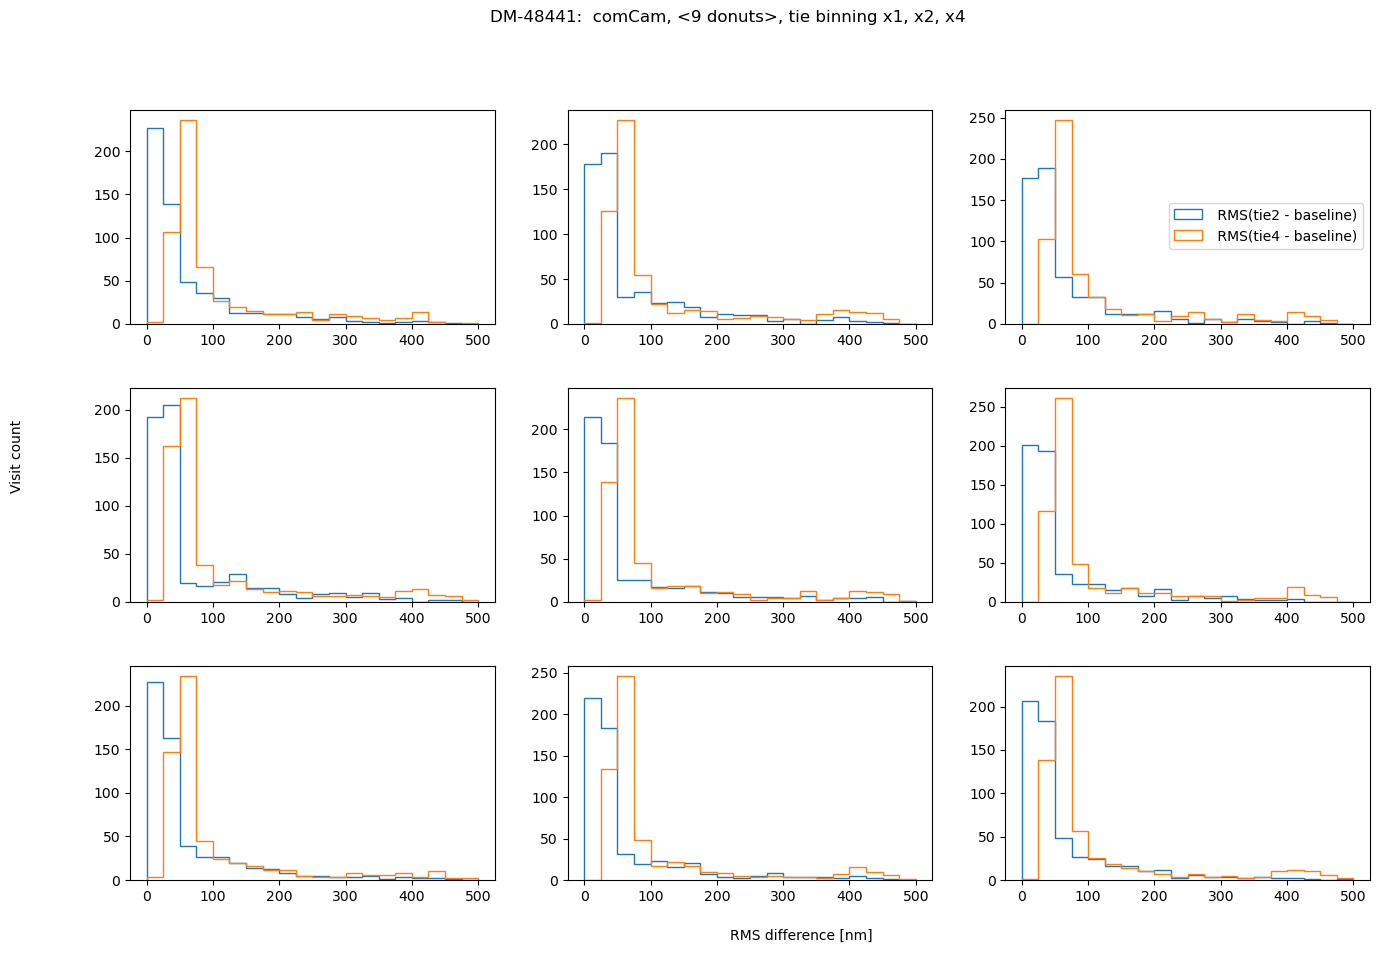

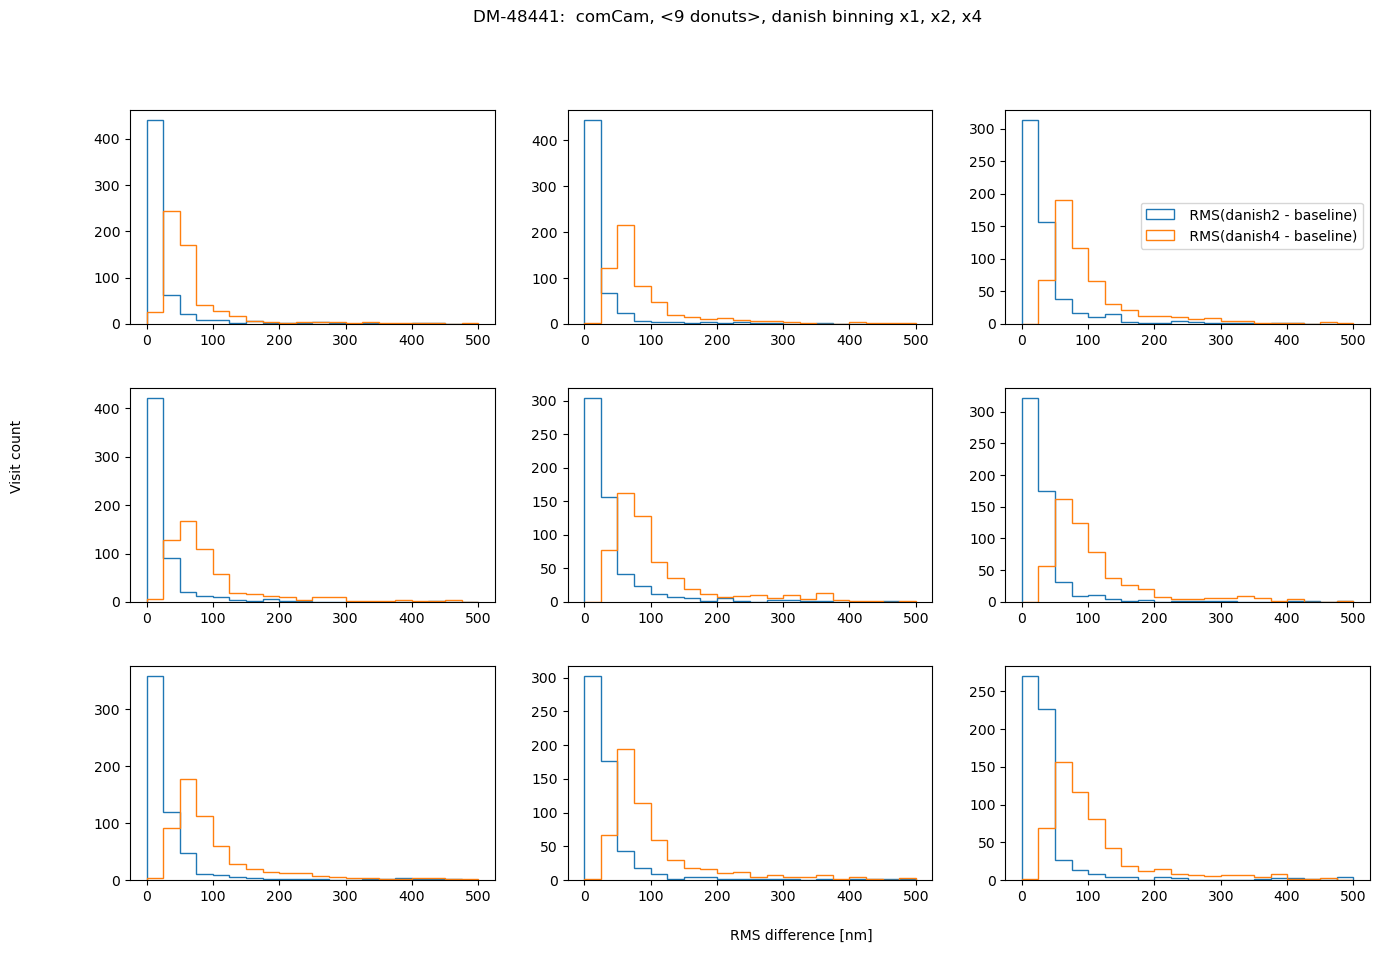

In [62]:
rms_per_met = {}
for met in ['tie', 'danish']:
    
    rms_per_det = {}
    
    for i in range(9):
        rms_per_det[i] = {f'{met}2':[], f'{met}4':[]}
    

    for visit in zk_diff_tie_danish[met].keys():
        for method in [  f'{met}2', f'{met}4']:
            for i in range(9):
                results = zk_diff_tie_danish[met][visit][method][i]['rms_diff']
                rms_per_det[i][method].append(results)
    rms_per_met[met] = rms_per_det
                

Nvisits = len(zk_diff_tie_danish[met].keys())

# plotting         
Nmin = 1 
for met in ['tie', 'danish']:
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)
    
    for i in range(9):
        for method in [  f'{met}2', f'{met}4']:
            ax[i].hist( rms_per_met[met][i][method], histtype='step', lw=3, bins=20, label=f' RMS({method} - baseline)',
                      range=[0,500])
        
    ax[2].legend(bbox_to_anchor=[1.,0.6], title='')
    fig.text(0.5,0.05, 'RMS difference [nm]')
    fig.text(0.05,0.5,  r'Visit count ', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'DM-48441:  comCam, <9 donuts>, {met} binning x1, x2, x4 ')

also in asec: 

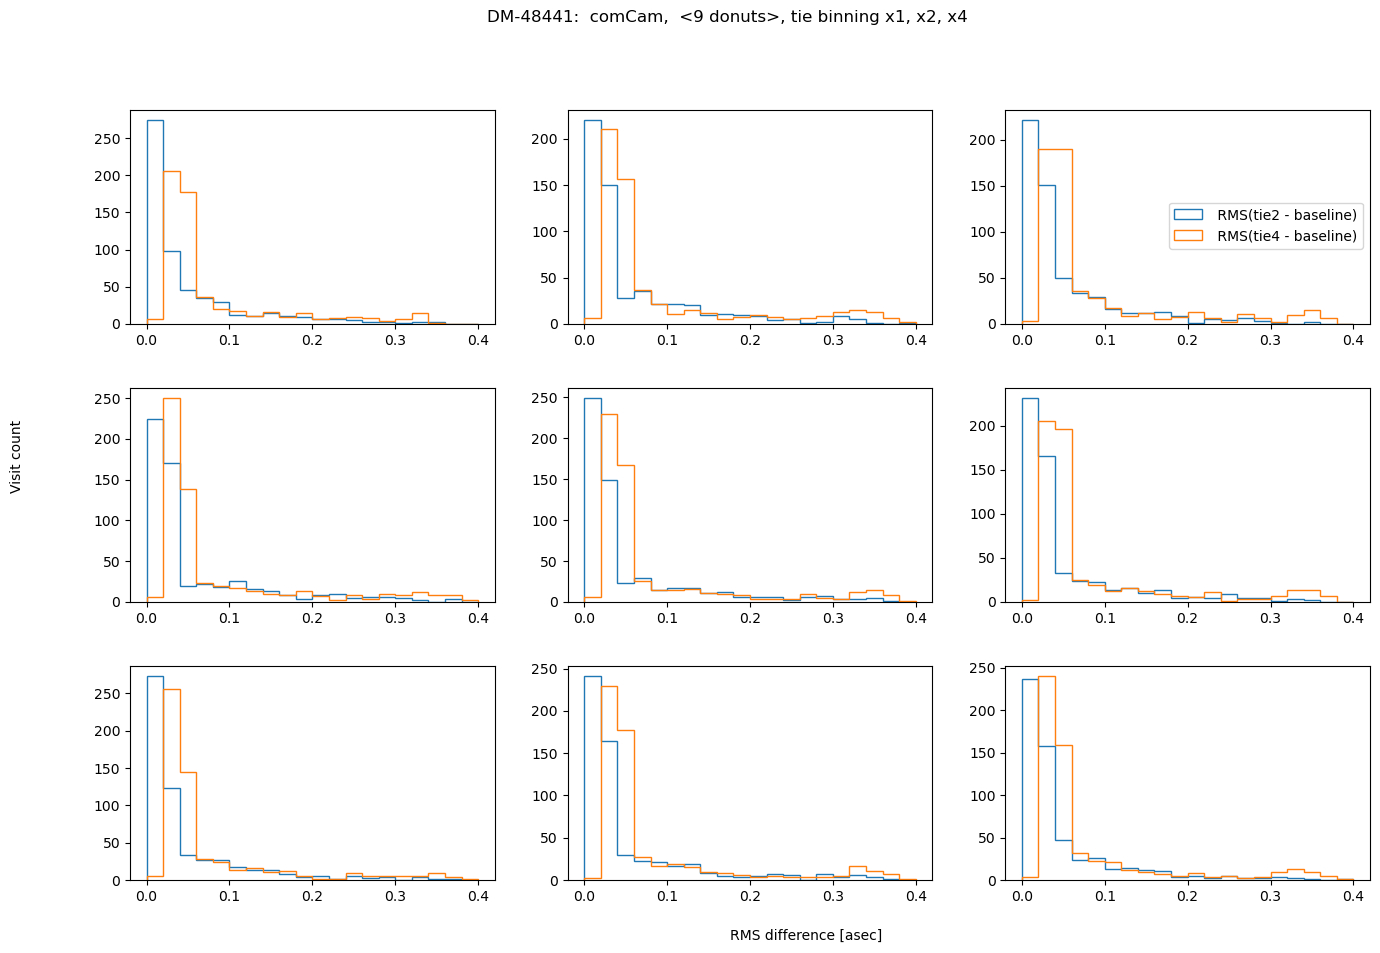

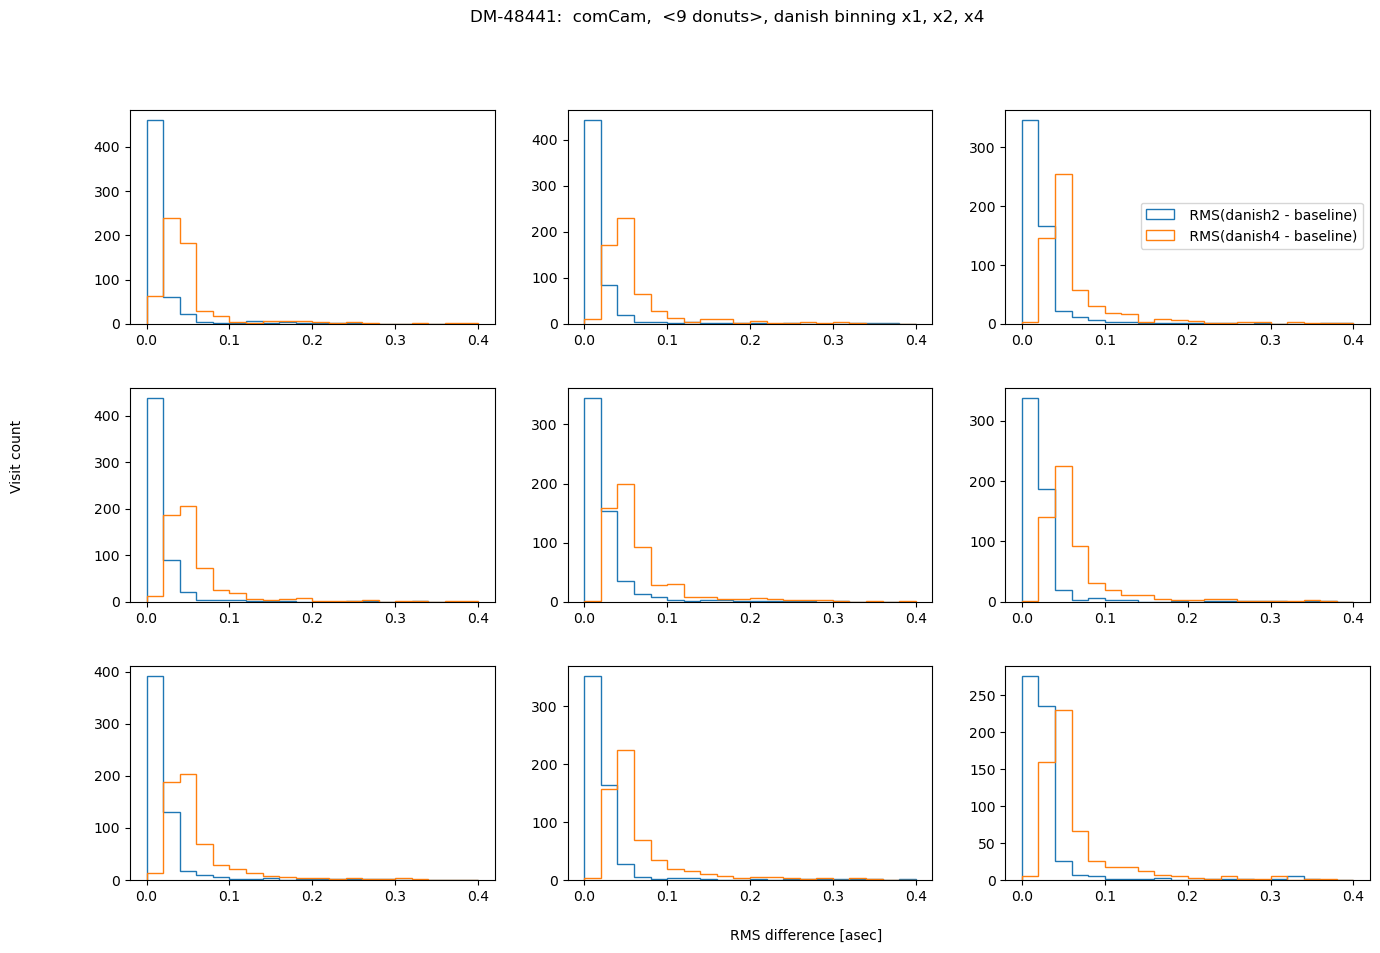

In [63]:
rms_per_met = {}
for met in ['tie', 'danish']:
    
    rms_per_det = {}
    
    for i in range(9):
        rms_per_det[i] = {f'{met}2':[], f'{met}4':[]}
    

    for visit in zk_diff_tie_danish[met].keys():
        for method in [  f'{met}2', f'{met}4']:
            for i in range(9):
                results = zk_diff_tie_danish[met][visit][method][i]['rms_diff_asec']
                rms_per_det[i][method].append(results)
    rms_per_met[met] = rms_per_det
                

Nvisits = len(zk_diff_tie_danish[met].keys())

# plotting         
Nmin = 1 
for met in ['tie', 'danish']:
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)
    
    for i in range(9):
        for method in [  f'{met}2', f'{met}4']:
            ax[i].hist( rms_per_met[met][i][method], histtype='step', lw=3, bins=20, label=f' RMS({method} - baseline)',
                      range=[0,0.4])
        
    ax[2].legend(bbox_to_anchor=[1.,0.6], title='')
    fig.text(0.5,0.05, 'RMS difference [asec]')
    fig.text(0.05,0.5,  r'Visit count ', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'DM-48441:  comCam,  <9 donuts>, {met} binning x1, x2, x4 ')

## Summary

In conclusion, choosing binning of x2 for either TIE or Danish vs no binning does not result in a significant RMS deviation (<0.1 asec). However, using binning x4 is not recommended for Danish as it causes twice as large RMS departure. Comparing the amount of information in 1 donut pair, increasing that all the way to 9 donut pairs, we note that for brighter mean magnitude (<12 mag), the  median RMS departure is < 0.01 asec from the single donut pair to a median of 9 donut pairs.  For all magnitude ranges, Danish more quickly arrives at the final answer (less donuts pairs necessary to achieve the same stability of estimated wavefront). 